In [1]:
# Imports
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from collections import deque
from collections import namedtuple

import random

from tqdm import tqdm
# import tqdm
# import tqdm.notebook
from itertools import count

from datetime import datetime

import gymnasium as gym

import matplotlib.pyplot as plt
import wandb

---
# Exercise 3.1: Solving Lunar Lander with `REINFORCE` (easy)

Use my (or even better, improve on my) implementation of `REINFORCE` to solve the [Lunar Lander Environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/). This environment is a little bit harder than Cartpole, but not much. Make sure you perform the same types of analyses we did during the lab session to quantify and qualify the performance of your agents.

In [2]:
# TRAIN AGENT
def train_agent(agent, agent_name, env, env_name, episodes, stats_every=100, name_exercise=None, wb=True, device="cuda"):
    # Initialize wandb
    if wb: wandb_init(agent, agent_name, env_name, episodes, device=device)

    # Track episode rewards in a list
    scores = []
    tot_reward = 0

    # Loop over the episodes
    for episode in tqdm(range(episodes), desc="Episodes", unit="episode", leave=True):
        # Initialize lists to store the states, actions, and rewards
        state_list = []
        action_list = []
        reward_list = []

        # Generate the episode
        stats_actor_loss, stats_v_loss = 0, 0
        (state, info) = env.reset()

        # Run the episode  
        for step in count():
            # Select an action
            action = agent.act(state)

            # Do the action in the environment
            next_state, reward, term, trunc, _ = env.step(action)

            tot_reward += reward

            # Store the state, action, and reward
            state_list.append(state)
            action_list.append(action)
            reward_list.append(reward)

            state = next_state

            # If the episode is done, break
            done = term or trunc
            if done:
                break   
        
        a_loss, v_loss = agent.train(state_list, action_list, reward_list)

        stats_actor_loss += a_loss
        stats_v_loss += v_loss

        # Wandb logging training stats
        scores.append((episode, tot_reward, step))
        if wb: wandb.log({"train/total_reward": tot_reward, "train/episode_length": step, "train/actor_loss": a_loss, "train/value_loss": v_loss}, step=episode)

        tot_reward = 0
        if not episode % stats_every:
            # Evaluate the agent
            total_reward = np.mean(scores[-stats_every:], axis=0)[1]
            total_length = np.mean(scores[-stats_every:], axis=0)[2]
            actor_loss = stats_actor_loss/stats_every
            value_loss = stats_v_loss/stats_every
            
            # Print stats and log to wandb
            print(f"Episode {episode}, Time steps: {step}, Total reward: {total_reward:.1f}, Episode length: {total_length:.1f}, Actor Loss: {actor_loss:.3f}, Value Loss: {value_loss:.3f}")
            if wb: wandb.log({"eval/time_steps": step, "eval/total_reward": total_reward, "eval/episode_length": total_length, "eval/actor_loss": actor_loss, "eval/value_loss": value_loss}, step=episode)

            # stopping condition for training if agent reaches the amount of reward
            if np.mean(scores[-stats_every:], axis=0)[1] >= 200.00:
                print("Stopping at episode {} with average rewards of {} in last {} episodes".
                    format(episode, np.mean(scores[-stats_every:],axis=0)[1], stats_every))
                torch.save(agent.actor.state_dict(), f"model_states/{agent_name}_actor_episode_{episode}.pth")
                torch.save(agent.actor.state_dict(), f"model_states/{agent_name}_value_episode_{episode}.pth")
                # Visualize the agent
                if name_exercise is not None:
                    show_video_of_model(agent, env_name, name_exercise)
                    # show_video(env_name, name_exercise)
                break
    
    # Close the environment
    env.close()
    # Finish wandb
    if wb: wandb.finish()
    
    # Plot 
    plot_stats(scores)

    return scores


def plot_stats(stats_rewards_list):
    # plot stats
    def get_running_stat(stat, stat_len):
        cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
        return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

    episode, r, l = np.array(stats_rewards_list).T
    cum_r = get_running_stat(r, 10)
    cum_l = get_running_stat(l, 10)

    # Plots
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].set_title("Episode reward")
    ax[0].plot(episode[-len(cum_r):], cum_r)
    ax[0].plot(episode, r, alpha=0.3)
    ax[0].set_xlabel("Episode")
    ax[0].set_ylabel("Episode reward")

    ax[1].set_title("Episode length")
    ax[1].plot(episode[-len(cum_l):], cum_l)
    ax[1].plot(episode, l, alpha=0.3)
    ax[1].set_xlabel("Episode")
    ax[1].set_ylabel("Episode length")
    

# Function to initialize wandb
def wandb_init(agent, algorithm, env, episodes, device="cuda", project="DLA Assigment 3"):
    # Initialize wandb
    wandb.init(
        project=project,
        name=algorithm,
        # Track hyperparameters and run metadata
        config={
            "algorithm": algorithm,
            "environment": env,
            "episodes": episodes,
            "learning_rate": agent.lr,
            "gamma": agent.gamma,
            "optimizer": "Adam",
            "device": device.type
        }
    )


def show_video_of_model(agent, env_name, name_exercise, file_path=None):
    if file_path is not None:
        agent.actor.load_state_dict(torch.load(file_path))

    env = gym.make(env_name, render_mode="rgb_array")
    env = gym.wrappers.RecordVideo(env=env, video_folder=f"video/{env_name}", name_prefix=name_exercise, disable_logger=True)

    obs, info = env.reset()

    env.start_video_recorder()

    for _ in count():
        action = agent.act(obs, 0)
        obs, rew, term, trunc, info = env.step(action)
        env.render()

        if term or trunc:
            obs, info = env.reset()
            break
            
    env.close_video_recorder()

    env.close()

In [3]:
# Policy network
class PolicyNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, s):
        return self.net(s)
    
# Value network
class ValueNet(nn.Module):
    def __init__(self, state_size, hidden_size=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
    def forward(self, s):
        return self.net(s)

In [4]:
# REINFORCE AGENT
class REINFORCEAgent():
    def __init__(self, state_size, action_size, hidden_size, lr, gamma, baseline=True, device='cuda'):
        self.action_size = action_size
        self.actor = PolicyNet(state_size, action_size, hidden_size).to(device)
        self.act_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.baseline = baseline
        self.value = ValueNet(state_size, hidden_size).to(device)
        self.value_optimizer = optim.Adam(self.value.parameters(), lr=lr)
        self.lr = lr
        self.gamma = gamma

    def act(self, state, device='cuda'):
        with torch.no_grad():
            state = torch.FloatTensor(state).to(device)
            probs = self.actor(state)
            probs  = probs.detach().cpu().numpy()
            action = np.random.choice(np.arange(self.action_size), p=probs)
        return action

    def train(self, state_list, action_list, reward_list, device='cuda'):
        # Transform the reward to a return
        len_rew = len(reward_list)
        return_array = np.zeros((len_rew))

        # Compute the return: G_t = r_t + gamma * r_{t+1} + gamma^2 * r_{t+2} + ...
        g_return = 0.
        for i in reversed(range(len_rew)):
            g_return = reward_list[i] + self.gamma * g_return
            return_array[i] = g_return

        # Transform the lists to tensors
        states = torch.FloatTensor(state_list).to(device)
        actions = torch.LongTensor(action_list).to(device).view(-1, 1)
        returns = torch.FloatTensor(return_array).to(device).view(-1, 1)

        # Get value function estimates
        if self.baseline: 
            values = self.value(states).to(device)
            with torch.no_grad():
                advantages = returns - values
        else:
            advantages = returns

        # Compute the loss
        selected_action_prob = self.actor(states).gather(1, actions)

        # REINFORCE with BASELINE loss
        actor_loss = -torch.mean(torch.log(selected_action_prob) * advantages)

        # Optimize the actor
        self.act_optimizer.zero_grad()
        actor_loss.backward()
        self.act_optimizer.step()

        # Compute the value loss
        if self.baseline:
            value_loss = F.mse_loss(values, returns)
            self.value_optimizer.zero_grad()
            value_loss.backward()
            self.value_optimizer.step()

        return actor_loss.detach().cpu().numpy(), value_loss.detach().cpu().numpy() if self.baseline else 0

## Without Baseline

### Cartpole

Episodes:   0%|          | 0/2000 [00:00<?, ?episode/s]

Episode 0, Time steps: 12, Total reward: 13.0, Episode length: 12.0, Actor Loss: 0.045, Value Loss: 0.000


Episodes:   5%|▍         | 99/2000 [00:02<01:23, 22.68episode/s]

Episode 100, Time steps: 74, Total reward: 33.0, Episode length: 32.0, Actor Loss: 0.172, Value Loss: 0.000


Episodes:  10%|▉         | 197/2000 [00:07<01:53, 15.88episode/s]

Episode 200, Time steps: 25, Total reward: 56.8, Episode length: 55.8, Actor Loss: 0.074, Value Loss: 0.000


Episodes:  15%|█▌        | 300/2000 [00:10<00:49, 34.15episode/s]

Episode 300, Time steps: 30, Total reward: 53.9, Episode length: 52.9, Actor Loss: 0.037, Value Loss: 0.000


Episodes:  20%|█▉        | 397/2000 [00:14<00:44, 35.77episode/s]

Episode 400, Time steps: 47, Total reward: 59.6, Episode length: 58.6, Actor Loss: 0.067, Value Loss: 0.000


Episodes:  25%|██▌       | 500/2000 [00:32<07:47,  3.21episode/s]

Episode 500, Time steps: 499, Total reward: 289.3, Episode length: 288.3, Actor Loss: 0.125, Value Loss: 0.000
Stopping at episode 500 with average rewards of 289.34 in last 100 episodes


c:\Users\loreb\miniconda3\envs\DLA\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\loreb\Documents\Projects\DLA\Lab3\video\CartPole-v1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Episodes:  25%|██▌       | 500/2000 [00:35<01:47, 13.91episode/s]


eval/actor_loss,▁█▃▁▃▆
eval/episode_length,▁▂▂▂▂█
eval/time_steps,▁▂▁▁▂█
eval/total_reward,▁▂▂▂▂█
eval/value_loss,▁▁▁▁▁▁
train/actor_loss,▁▂▄▁▁▆▂▄▄▃▂▂▃▄▄▆▁▁▁▁▄█▃▂▁▁▃▄▁▁▂▂▂▂▃▄▅▄▄▅
train/episode_length,▁▁▁▁▁▂▁▂▂▁▁▁▁▂▂▃▁▁▁▁▂▄▂▁▁▁▂▃▂▁▁▁▂▂▃▃▇███
train/total_reward,▁▁▁▁▁▂▁▂▂▁▁▁▁▂▂▃▁▁▁▁▂▄▂▁▁▁▂▃▂▁▁▁▂▂▃▃▇███
train/value_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/actor_loss,0.12539
eval/episode_length,288.34


[(0, 13.0, 12),
 (1, 13.0, 12),
 (2, 52.0, 51),
 (3, 15.0, 14),
 (4, 12.0, 11),
 (5, 16.0, 15),
 (6, 21.0, 20),
 (7, 13.0, 12),
 (8, 35.0, 34),
 (9, 13.0, 12),
 (10, 10.0, 9),
 (11, 9.0, 8),
 (12, 20.0, 19),
 (13, 20.0, 19),
 (14, 18.0, 17),
 (15, 25.0, 24),
 (16, 56.0, 55),
 (17, 11.0, 10),
 (18, 16.0, 15),
 (19, 11.0, 10),
 (20, 18.0, 17),
 (21, 23.0, 22),
 (22, 36.0, 35),
 (23, 15.0, 14),
 (24, 20.0, 19),
 (25, 16.0, 15),
 (26, 16.0, 15),
 (27, 44.0, 43),
 (28, 12.0, 11),
 (29, 31.0, 30),
 (30, 16.0, 15),
 (31, 20.0, 19),
 (32, 19.0, 18),
 (33, 28.0, 27),
 (34, 49.0, 48),
 (35, 24.0, 23),
 (36, 36.0, 35),
 (37, 27.0, 26),
 (38, 23.0, 22),
 (39, 17.0, 16),
 (40, 20.0, 19),
 (41, 31.0, 30),
 (42, 10.0, 9),
 (43, 45.0, 44),
 (44, 24.0, 23),
 (45, 17.0, 16),
 (46, 12.0, 11),
 (47, 29.0, 28),
 (48, 19.0, 18),
 (49, 22.0, 21),
 (50, 18.0, 17),
 (51, 16.0, 15),
 (52, 20.0, 19),
 (53, 17.0, 16),
 (54, 13.0, 12),
 (55, 18.0, 17),
 (56, 15.0, 14),
 (57, 40.0, 39),
 (58, 19.0, 18),
 (59, 21.0,

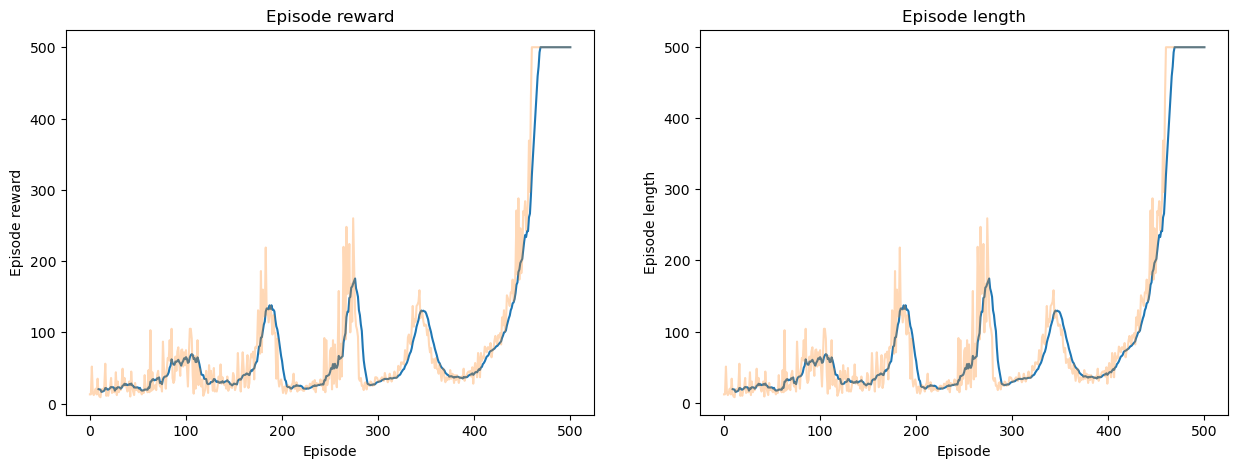

In [8]:
# Initialize the environment.
env_name = "CartPole-v1"
env = gym.make(env_name)
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]
# print("Action size:", action_size, "State size:", state_size)

# Hyperparameters
lr = 5e-3
gamma = 0.99
hidden_dim = 64
episodes = 2000
stats_every = 100 

# Initialize the policy agent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
date = datetime.now().strftime("%Y%m%d-%H%M%S")
baseline = False
agent_name = "REINFORCE" + ("_BASELINE" if baseline else "")
agent_name = agent_name + "_" + date
agent = REINFORCEAgent(state_dim, action_dim, hidden_dim, lr, gamma, baseline=baseline, device=device)

name_exercise = "cartpole-not-baseline"

# Train the agent
train_agent(
    agent=agent,
    agent_name=agent_name,
    env=env,
    env_name=env_name,
    episodes=episodes,
    stats_every=stats_every,
    name_exercise=name_exercise,
    wb=True,
    device=device
)

### Lunar Lander

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lorebaia. Use `wandb login --relogin` to force relogin


Episodes:   0%|          | 0/5000 [00:00<?, ?episode/s]C:\Users\loreb\AppData\Local\Temp\ipykernel_15388\588853755.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:277.)
  states = torch.FloatTensor(state_list).to(device)


Episode 0, Time steps: 104, Total reward: -399.7, Episode length: 104.0, Actor Loss: -2.778, Value Loss: 0.000


Episodes:   2%|▏         | 99/5000 [00:08<06:18, 12.96episode/s] 

Episode 100, Time steps: 143, Total reward: -178.5, Episode length: 97.5, Actor Loss: -1.309, Value Loss: 0.000


Episodes:   4%|▍         | 199/5000 [00:14<05:28, 14.60episode/s]

Episode 200, Time steps: 135, Total reward: -146.2, Episode length: 86.8, Actor Loss: -1.024, Value Loss: 0.000


Episodes:   6%|▌         | 300/5000 [00:23<07:09, 10.95episode/s]

Episode 300, Time steps: 149, Total reward: -162.2, Episode length: 108.1, Actor Loss: -0.730, Value Loss: 0.000


Episodes:   8%|▊         | 400/5000 [00:32<06:25, 11.93episode/s]

Episode 400, Time steps: 110, Total reward: -134.4, Episode length: 107.2, Actor Loss: -0.799, Value Loss: 0.000


Episodes:  10%|█         | 500/5000 [00:41<07:04, 10.61episode/s]

Episode 500, Time steps: 98, Total reward: -137.3, Episode length: 136.9, Actor Loss: -1.953, Value Loss: 0.000


Episodes:  12%|█▏        | 600/5000 [00:54<08:17,  8.84episode/s]

Episode 600, Time steps: 306, Total reward: -84.7, Episode length: 169.6, Actor Loss: -0.659, Value Loss: 0.000


Episodes:  14%|█▍        | 700/5000 [01:13<13:34,  5.28episode/s]

Episode 700, Time steps: 273, Total reward: -119.5, Episode length: 275.2, Actor Loss: -0.652, Value Loss: 0.000


Episodes:  16%|█▌        | 800/5000 [01:42<24:10,  2.89episode/s]

Episode 800, Time steps: 428, Total reward: -107.8, Episode length: 412.8, Actor Loss: -0.548, Value Loss: 0.000


Episodes:  18%|█▊        | 900/5000 [02:46<48:09,  1.42episode/s]

Episode 900, Time steps: 874, Total reward: -78.8, Episode length: 757.6, Actor Loss: -0.482, Value Loss: 0.000


Episodes:  20%|██        | 1000/5000 [03:51<53:49,  1.24episode/s]

Episode 1000, Time steps: 999, Total reward: -51.0, Episode length: 810.6, Actor Loss: -0.055, Value Loss: 0.000


Episodes:  22%|██▏       | 1100/5000 [04:48<45:32,  1.43episode/s]

Episode 1100, Time steps: 999, Total reward: -49.6, Episode length: 829.7, Actor Loss: -0.058, Value Loss: 0.000


Episodes:  24%|██▍       | 1200/5000 [05:54<51:04,  1.24episode/s]

Episode 1200, Time steps: 999, Total reward: -32.0, Episode length: 813.8, Actor Loss: -0.068, Value Loss: 0.000


Episodes:  26%|██▌       | 1300/5000 [07:00<48:21,  1.28episode/s]

Episode 1300, Time steps: 999, Total reward: -18.5, Episode length: 942.1, Actor Loss: -0.020, Value Loss: 0.000


Episodes:  28%|██▊       | 1400/5000 [08:10<46:27,  1.29episode/s]

Episode 1400, Time steps: 999, Total reward: -46.5, Episode length: 880.1, Actor Loss: -0.082, Value Loss: 0.000


Episodes:  30%|███       | 1500/5000 [09:27<45:29,  1.28episode/s]

Episode 1500, Time steps: 96, Total reward: -28.1, Episode length: 976.3, Actor Loss: 0.146, Value Loss: 0.000


Episodes:  32%|███▏      | 1600/5000 [10:33<43:29,  1.30episode/s]

Episode 1600, Time steps: 999, Total reward: -13.3, Episode length: 832.7, Actor Loss: -0.072, Value Loss: 0.000


Episodes:  34%|███▍      | 1700/5000 [11:48<44:21,  1.24episode/s]

Episode 1700, Time steps: 999, Total reward: -13.1, Episode length: 964.9, Actor Loss: -0.008, Value Loss: 0.000


Episodes:  36%|███▌      | 1800/5000 [13:03<40:06,  1.33episode/s]

Episode 1800, Time steps: 999, Total reward: -21.3, Episode length: 933.7, Actor Loss: -0.096, Value Loss: 0.000


Episodes:  38%|███▊      | 1899/5000 [14:09<27:23,  1.89episode/s]

Episode 1900, Time steps: 999, Total reward: -13.0, Episode length: 807.2, Actor Loss: -0.035, Value Loss: 0.000


Episodes:  40%|████      | 2000/5000 [15:02<34:30,  1.45episode/s]

Episode 2000, Time steps: 942, Total reward: -13.8, Episode length: 640.3, Actor Loss: -0.152, Value Loss: 0.000


Episodes:  42%|████▏     | 2100/5000 [15:54<36:10,  1.34episode/s]

Episode 2100, Time steps: 999, Total reward: -15.4, Episode length: 639.8, Actor Loss: -0.005, Value Loss: 0.000


Episodes:  44%|████▍     | 2200/5000 [16:51<27:21,  1.71episode/s]

Episode 2200, Time steps: 999, Total reward: 4.7, Episode length: 702.9, Actor Loss: -0.037, Value Loss: 0.000


Episodes:  46%|████▌     | 2300/5000 [18:06<37:05,  1.21episode/s]

Episode 2300, Time steps: 999, Total reward: -12.5, Episode length: 907.6, Actor Loss: -0.046, Value Loss: 0.000


Episodes:  48%|████▊     | 2400/5000 [19:25<34:50,  1.24episode/s]

Episode 2400, Time steps: 999, Total reward: -5.8, Episode length: 990.9, Actor Loss: -0.020, Value Loss: 0.000


Episodes:  50%|█████     | 2500/5000 [20:43<33:42,  1.24episode/s]

Episode 2500, Time steps: 999, Total reward: 8.3, Episode length: 967.4, Actor Loss: -0.030, Value Loss: 0.000


Episodes:  52%|█████▏    | 2600/5000 [22:07<36:00,  1.11episode/s]

Episode 2600, Time steps: 999, Total reward: 11.1, Episode length: 985.4, Actor Loss: -0.039, Value Loss: 0.000


Episodes:  54%|█████▍    | 2700/5000 [23:25<29:38,  1.29episode/s]

Episode 2700, Time steps: 999, Total reward: 11.1, Episode length: 973.9, Actor Loss: 0.017, Value Loss: 0.000


Episodes:  56%|█████▌    | 2800/5000 [24:11<12:40,  2.89episode/s]

Episode 2800, Time steps: 225, Total reward: 3.7, Episode length: 576.2, Actor Loss: 0.393, Value Loss: 0.000


Episodes:  58%|█████▊    | 2900/5000 [25:25<27:26,  1.28episode/s]

Episode 2900, Time steps: 709, Total reward: -6.9, Episode length: 932.9, Actor Loss: 0.055, Value Loss: 0.000


Episodes:  60%|██████    | 3000/5000 [26:43<26:20,  1.27episode/s]

Episode 3000, Time steps: 999, Total reward: 16.3, Episode length: 962.5, Actor Loss: -0.032, Value Loss: 0.000


Episodes:  62%|██████▏   | 3100/5000 [28:02<24:24,  1.30episode/s]

Episode 3100, Time steps: 999, Total reward: 33.0, Episode length: 983.0, Actor Loss: -0.010, Value Loss: 0.000


Episodes:  64%|██████▍   | 3200/5000 [29:15<22:12,  1.35episode/s]

Episode 3200, Time steps: 999, Total reward: 62.4, Episode length: 891.0, Actor Loss: -0.003, Value Loss: 0.000


Episodes:  66%|██████▌   | 3300/5000 [30:21<22:19,  1.27episode/s]

Episode 3300, Time steps: 999, Total reward: 53.5, Episode length: 841.4, Actor Loss: 0.006, Value Loss: 0.000


Episodes:  68%|██████▊   | 3400/5000 [31:33<19:30,  1.37episode/s]

Episode 3400, Time steps: 170, Total reward: 58.3, Episode length: 859.6, Actor Loss: 0.017, Value Loss: 0.000


Episodes:  70%|███████   | 3500/5000 [32:34<20:20,  1.23episode/s]

Episode 3500, Time steps: 999, Total reward: 81.5, Episode length: 799.1, Actor Loss: 0.040, Value Loss: 0.000


Episodes:  72%|███████▏  | 3600/5000 [33:30<19:50,  1.18episode/s]

Episode 3600, Time steps: 999, Total reward: 99.6, Episode length: 684.0, Actor Loss: -0.002, Value Loss: 0.000


Episodes:  74%|███████▍  | 3700/5000 [34:28<05:31,  3.93episode/s]

Episode 3700, Time steps: 351, Total reward: 107.1, Episode length: 703.2, Actor Loss: 0.303, Value Loss: 0.000


Episodes:  76%|███████▌  | 3800/5000 [35:12<12:55,  1.55episode/s]

Episode 3800, Time steps: 999, Total reward: 130.5, Episode length: 540.9, Actor Loss: 0.037, Value Loss: 0.000


Episodes:  78%|███████▊  | 3900/5000 [36:05<05:26,  3.37episode/s]

Episode 3900, Time steps: 372, Total reward: 117.7, Episode length: 651.4, Actor Loss: 0.343, Value Loss: 0.000


Episodes:  80%|████████  | 4000/5000 [37:01<06:49,  2.44episode/s]

Episode 4000, Time steps: 692, Total reward: -1.5, Episode length: 690.0, Actor Loss: 0.012, Value Loss: 0.000


Episodes:  82%|████████▏ | 4100/5000 [38:04<09:19,  1.61episode/s]

Episode 4100, Time steps: 999, Total reward: 5.0, Episode length: 802.6, Actor Loss: 0.025, Value Loss: 0.000


Episodes:  84%|████████▍ | 4200/5000 [39:20<10:32,  1.27episode/s]

Episode 4200, Time steps: 999, Total reward: 137.6, Episode length: 925.3, Actor Loss: 0.072, Value Loss: 0.000


Episodes:  86%|████████▌ | 4300/5000 [40:36<09:00,  1.29episode/s]

Episode 4300, Time steps: 999, Total reward: 134.9, Episode length: 909.0, Actor Loss: 0.059, Value Loss: 0.000


Episodes:  88%|████████▊ | 4400/5000 [41:53<08:02,  1.24episode/s]

Episode 4400, Time steps: 999, Total reward: 136.2, Episode length: 948.6, Actor Loss: 0.071, Value Loss: 0.000


Episodes:  90%|█████████ | 4500/5000 [43:13<05:52,  1.42episode/s]

Episode 4500, Time steps: 882, Total reward: 136.4, Episode length: 945.7, Actor Loss: 0.088, Value Loss: 0.000


Episodes:  92%|█████████▏| 4600/5000 [44:29<05:35,  1.19episode/s]

Episode 4600, Time steps: 999, Total reward: 128.2, Episode length: 948.4, Actor Loss: 0.102, Value Loss: 0.000


Episodes:  94%|█████████▍| 4700/5000 [45:45<02:52,  1.74episode/s]

Episode 4700, Time steps: 457, Total reward: 137.0, Episode length: 924.2, Actor Loss: 0.267, Value Loss: 0.000


Episodes:  96%|█████████▌| 4800/5000 [46:54<02:31,  1.32episode/s]

Episode 4800, Time steps: 999, Total reward: 127.3, Episode length: 854.9, Actor Loss: 0.057, Value Loss: 0.000


Episodes:  98%|█████████▊| 4900/5000 [48:13<01:22,  1.22episode/s]

Episode 4900, Time steps: 999, Total reward: 116.9, Episode length: 979.1, Actor Loss: 0.083, Value Loss: 0.000


Episodes: 100%|██████████| 5000/5000 [49:34<00:00,  1.68episode/s]


eval/actor_loss,▁▄▅▆▃▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇█▇▇▇▇▇▇▇█▇
eval/episode_length,▁▁▁▁▁▂▂▄▇▇▇██▇██▅▅▆▇███▅██▇▇▇▆▆▅▆▇█▇████
eval/time_steps,▁▁▁▁▁▃▂▄████▁██████████▂██████▃█▆███▇█▄█
eval/total_reward,▁▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇███▆▆██████
eval/value_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/actor_loss,▁▁▅▅▆▃▅▆▄▆▆▆▇▇▇▅▇▆▆▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇
train/episode_length,▁▁▁▁▂▂▅█▃████▂█▂█████████████▃██▅███████
train/total_reward,▂▂▄▄▅▂▁▄▂▅▅▅▅▅▆▃▆▄▅▆▅▆▆▆▆▆▆▆▇█▆▄█▇▇▇██▇▇
train/value_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/actor_loss,0.08317
eval/episode_length,979.15


[(0, -399.6854729563293, 104),
 (1, -122.30893707024063, 94),
 (2, -72.75471926894618, 69),
 (3, -41.884789527453336, 69),
 (4, -106.66796161858369, 85),
 (5, -378.17357471401436, 94),
 (6, -80.02734734880352, 85),
 (7, -99.12118354327764, 68),
 (8, -311.32753219917333, 106),
 (9, -374.64544743075305, 78),
 (10, -103.31096589288269, 68),
 (11, -65.52868363006846, 84),
 (12, -336.3064999535006, 93),
 (13, -124.61189444887076, 69),
 (14, -151.22355957138018, 61),
 (15, -143.87282570251787, 131),
 (16, -150.7722716293996, 81),
 (17, -404.89294361202957, 118),
 (18, -363.8339966283014, 76),
 (19, -92.59115362044658, 89),
 (20, -231.94187388394613, 99),
 (21, -269.0131598812163, 83),
 (22, -120.36060176275718, 62),
 (23, -44.59100024462259, 65),
 (24, -76.6029769364305, 65),
 (25, -195.7129431788896, 66),
 (26, -150.1314289409459, 99),
 (27, -331.6679419203077, 96),
 (28, -66.5689310303015, 64),
 (29, -219.38023133840716, 86),
 (30, -208.7533101367681, 137),
 (31, -160.5153885982661, 100),


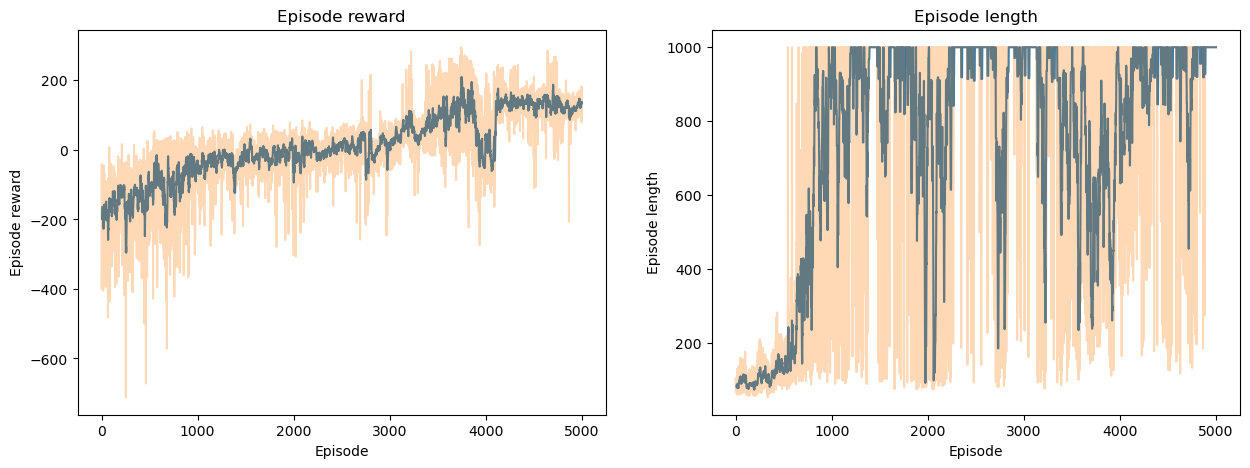

In [5]:
# Initialize the environment.
env_name = "LunarLander-v2"
env = gym.make(env_name)
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]
# print("Action size:", action_size, "State size:", state_size)

# Hyperparameters
lr = 5e-4
gamma = 0.99
hidden_dim = 256
episodes = 5000
stats_every = 100 

# Initialize the policy agent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dt = datetime.now().strftime("%Y%m%d-%H%M%S")
agent_name = "REINFORCE"
agent_name = agent_name + "_" + dt
agent = REINFORCEAgent(state_dim, action_dim, hidden_dim, lr, gamma, baseline=False, device=device)

name_exercise = "lunarlander-not-baseline"

# Train the agent
train_agent(
    agent=agent,
    agent_name=agent_name,
    env=env,
    env_name=env_name,
    episodes=episodes,
    stats_every=stats_every,
    name_exercise=name_exercise,
    wb=True,
    device=device
)

## With Deep Neural Network Baseline

### Cartpole Environment

Episodes:   0%|          | 0/2000 [00:00<?, ?episode/s]

Episode 0, Time steps: 27, Total reward: 28.0, Episode length: 27.0, Actor Loss: 0.093, Value Loss: 2.259


Episodes:   5%|▌         | 100/2000 [00:04<03:16,  9.65episode/s]

Episode 100, Time steps: 114, Total reward: 63.8, Episode length: 62.8, Actor Loss: 0.088, Value Loss: 7.700


Episodes:  10%|█         | 200/2000 [00:25<08:52,  3.38episode/s]

Episode 200, Time steps: 499, Total reward: 319.1, Episode length: 318.1, Actor Loss: 0.020, Value Loss: 6.345
Stopping at episode 200 with average rewards of 319.09 in last 100 episodes


c:\Users\loreb\miniconda3\envs\DLA\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\loreb\Documents\Projects\DLA\Lab3\video\CartPole-v1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Episodes:  10%|█         | 200/2000 [00:28<04:17,  7.00episode/s]


eval/actor_loss,██▁
eval/episode_length,▁▂█
eval/time_steps,▁▂█
eval/total_reward,▁▂█
eval/value_loss,▁█▆
train/actor_loss,▄▅▄▅▄▄▅▄▄▄▄▅▆▆▄▆▅█▅▅▅█▁▄▅▆▅▅▆▂▃▅▅▃▄▄▃▄▂▃
train/episode_length,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▂▂▄▂▂▃▆▁▃▄▅▄▄▆▃▄██▅█▆▅█▄█
train/total_reward,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▂▂▄▂▂▃▆▁▃▄▅▄▄▆▃▄██▅█▆▅█▄█
train/value_loss,▁▁▁▂▁▁▂▁▁▁▁▂▃▄▁▃▂▇▃▃▃█▁▃▄▄▃▃▄▂▂▄▃▃▃▃▂▂▂▂
eval/actor_loss,0.0203
eval/episode_length,318.09


[(0, 28.0, 27),
 (1, 21.0, 20),
 (2, 38.0, 37),
 (3, 43.0, 42),
 (4, 13.0, 12),
 (5, 31.0, 30),
 (6, 45.0, 44),
 (7, 24.0, 23),
 (8, 68.0, 67),
 (9, 20.0, 19),
 (10, 24.0, 23),
 (11, 23.0, 22),
 (12, 63.0, 62),
 (13, 32.0, 31),
 (14, 19.0, 18),
 (15, 43.0, 42),
 (16, 20.0, 19),
 (17, 48.0, 47),
 (18, 38.0, 37),
 (19, 10.0, 9),
 (20, 22.0, 21),
 (21, 15.0, 14),
 (22, 18.0, 17),
 (23, 65.0, 64),
 (24, 30.0, 29),
 (25, 28.0, 27),
 (26, 14.0, 13),
 (27, 24.0, 23),
 (28, 25.0, 24),
 (29, 25.0, 24),
 (30, 22.0, 21),
 (31, 37.0, 36),
 (32, 11.0, 10),
 (33, 21.0, 20),
 (34, 43.0, 42),
 (35, 20.0, 19),
 (36, 11.0, 10),
 (37, 33.0, 32),
 (38, 36.0, 35),
 (39, 16.0, 15),
 (40, 34.0, 33),
 (41, 27.0, 26),
 (42, 52.0, 51),
 (43, 17.0, 16),
 (44, 18.0, 17),
 (45, 34.0, 33),
 (46, 26.0, 25),
 (47, 32.0, 31),
 (48, 19.0, 18),
 (49, 32.0, 31),
 (50, 30.0, 29),
 (51, 24.0, 23),
 (52, 31.0, 30),
 (53, 63.0, 62),
 (54, 33.0, 32),
 (55, 56.0, 55),
 (56, 107.0, 106),
 (57, 70.0, 69),
 (58, 74.0, 73),
 (59, 

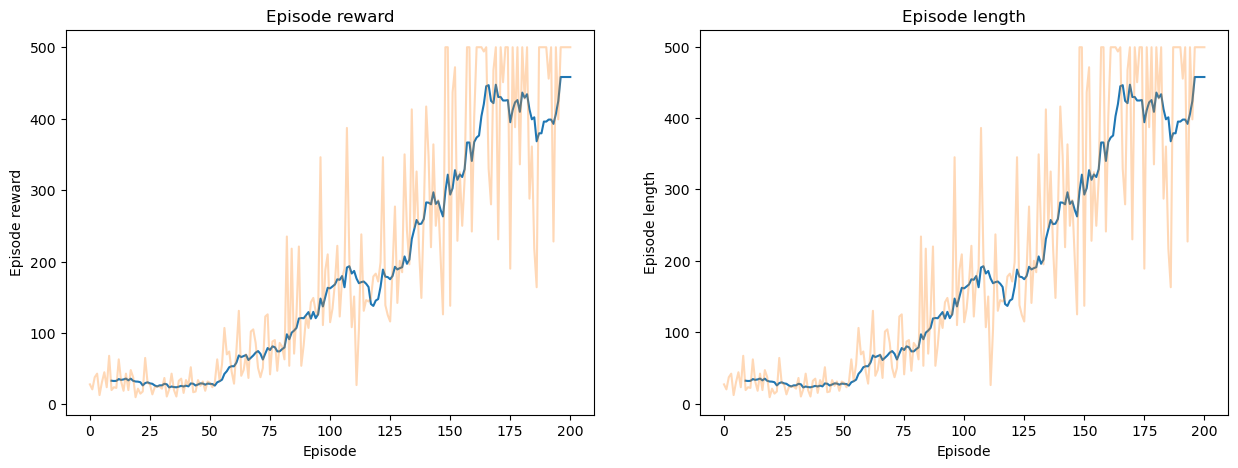

In [54]:
# Initialize the environment.
env_name = "CartPole-v1"
env = gym.make(env_name)
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]
# print("Action size:", action_size, "State size:", state_size)

# Hyperparameters
lr = 5e-3
gamma = 0.99
hidden_dim = 64
episodes = 2000
stats_every = 100 

# Initialize the policy agent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
date = datetime.now().strftime("%Y%m%d-%H%M%S")
baseline = True
agent_name = "REINFORCE" + ("_BASELINE" if baseline else "")
agent_name = agent_name + "_" + date
agent = REINFORCEAgent(state_dim, action_dim, hidden_dim, lr, gamma, baseline=baseline, device=device)

name_exercise = "cartpole-baseline"

# Train the agent
train_agent(
    agent=agent,
    agent_name=agent_name,
    env=env,
    env_name=env_name,
    episodes=episodes,
    stats_every=stats_every,
    name_exercise=name_exercise,
    wb=True,
    device=device
)

### Lunar Lander Environment

Episodes:   0%|          | 0/5000 [00:00<?, ?episode/s]

Episode 0, Time steps: 116, Total reward: -103.6, Episode length: 116.0, Actor Loss: -0.772, Value Loss: 32.170


Episodes:   2%|▏         | 99/5000 [00:07<05:24, 15.12episode/s]

Episode 100, Time steps: 56, Total reward: -176.2, Episode length: 89.3, Actor Loss: -0.604, Value Loss: 19.885


Episodes:   4%|▍         | 200/5000 [00:14<05:38, 14.18episode/s]

Episode 200, Time steps: 82, Total reward: -161.1, Episode length: 88.7, Actor Loss: -0.037, Value Loss: 4.871


Episodes:   6%|▌         | 300/5000 [00:21<05:12, 15.03episode/s]

Episode 300, Time steps: 88, Total reward: -123.5, Episode length: 90.1, Actor Loss: -0.137, Value Loss: 2.352


Episodes:   8%|▊         | 400/5000 [00:31<07:39, 10.01episode/s]

Episode 400, Time steps: 85, Total reward: -92.0, Episode length: 119.5, Actor Loss: 0.181, Value Loss: 8.990


Episodes:  10%|▉         | 499/5000 [00:42<07:19, 10.25episode/s]

Episode 500, Time steps: 189, Total reward: -64.3, Episode length: 132.7, Actor Loss: 0.162, Value Loss: 5.628


Episodes:  12%|█▏        | 599/5000 [00:54<10:14,  7.16episode/s]

Episode 600, Time steps: 212, Total reward: -42.6, Episode length: 167.0, Actor Loss: 0.012, Value Loss: 9.005


Episodes:  14%|█▍        | 700/5000 [01:09<08:46,  8.17episode/s]

Episode 700, Time steps: 113, Total reward: -28.8, Episode length: 184.9, Actor Loss: 0.009, Value Loss: 3.840


Episodes:  16%|█▌        | 799/5000 [01:40<24:38,  2.84episode/s]

Episode 800, Time steps: 569, Total reward: -34.3, Episode length: 391.2, Actor Loss: -0.198, Value Loss: 24.629


Episodes:  18%|█▊        | 900/5000 [02:20<20:37,  3.31episode/s]

Episode 900, Time steps: 127, Total reward: -45.8, Episode length: 551.1, Actor Loss: -0.154, Value Loss: 7.610


Episodes:  20%|██        | 1000/5000 [03:20<57:06,  1.17episode/s]

Episode 1000, Time steps: 999, Total reward: -38.1, Episode length: 809.8, Actor Loss: 0.177, Value Loss: 4.812


Episodes:  22%|██▏       | 1100/5000 [04:23<55:02,  1.18episode/s]

Episode 1100, Time steps: 999, Total reward: 27.3, Episode length: 849.3, Actor Loss: 0.000, Value Loss: 9.073


Episodes:  24%|██▍       | 1200/5000 [05:28<31:37,  2.00episode/s]  

Episode 1200, Time steps: 999, Total reward: 54.6, Episode length: 755.0, Actor Loss: 0.132, Value Loss: 9.378


Episodes:  26%|██▌       | 1300/5000 [06:33<21:00,  2.93episode/s]

Episode 1300, Time steps: 133, Total reward: 78.3, Episode length: 754.8, Actor Loss: 0.034, Value Loss: 9.116


Episodes:  28%|██▊       | 1400/5000 [07:17<18:05,  3.32episode/s]

Episode 1400, Time steps: 503, Total reward: 97.0, Episode length: 506.6, Actor Loss: -0.000, Value Loss: 19.267


Episodes:  30%|███       | 1500/5000 [08:07<39:48,  1.47episode/s]

Episode 1500, Time steps: 999, Total reward: 94.0, Episode length: 619.5, Actor Loss: 0.024, Value Loss: 4.373


Episodes:  32%|███▏      | 1600/5000 [09:03<23:39,  2.39episode/s]

Episode 1600, Time steps: 520, Total reward: 106.0, Episode length: 728.7, Actor Loss: 0.125, Value Loss: 19.372


Episodes:  34%|███▍      | 1700/5000 [09:53<36:48,  1.49episode/s]

Episode 1700, Time steps: 999, Total reward: 123.7, Episode length: 679.1, Actor Loss: -0.107, Value Loss: 5.366


Episodes:  36%|███▌      | 1800/5000 [11:18<49:12,  1.08episode/s]  

Episode 1800, Time steps: 999, Total reward: 116.9, Episode length: 985.8, Actor Loss: 0.039, Value Loss: 1.868


Episodes:  38%|███▊      | 1900/5000 [12:32<43:32,  1.19episode/s]

Episode 1900, Time steps: 999, Total reward: 143.9, Episode length: 907.0, Actor Loss: 0.048, Value Loss: 1.554


Episodes:  40%|████      | 2000/5000 [13:49<40:26,  1.24episode/s]

Episode 2000, Time steps: 999, Total reward: 137.8, Episode length: 960.4, Actor Loss: 0.046, Value Loss: 1.640


Episodes:  42%|████▏     | 2100/5000 [15:10<35:19,  1.37episode/s]

Episode 2100, Time steps: 999, Total reward: 128.1, Episode length: 970.4, Actor Loss: 0.042, Value Loss: 1.364


Episodes:  44%|████▍     | 2200/5000 [16:28<40:07,  1.16episode/s]

Episode 2200, Time steps: 999, Total reward: 130.8, Episode length: 978.0, Actor Loss: 0.047, Value Loss: 1.904


Episodes:  46%|████▌     | 2300/5000 [17:47<37:20,  1.21episode/s]

Episode 2300, Time steps: 999, Total reward: 132.7, Episode length: 928.0, Actor Loss: 0.006, Value Loss: 0.970


Episodes:  48%|████▊     | 2400/5000 [19:08<37:33,  1.15episode/s]

Episode 2400, Time steps: 999, Total reward: 144.6, Episode length: 966.0, Actor Loss: 0.018, Value Loss: 2.356


Episodes:  50%|█████     | 2500/5000 [20:26<23:19,  1.79episode/s]

Episode 2500, Time steps: 999, Total reward: 136.4, Episode length: 975.5, Actor Loss: -0.016, Value Loss: 0.473


Episodes:  52%|█████▏    | 2600/5000 [21:43<33:58,  1.18episode/s]

Episode 2600, Time steps: 999, Total reward: 125.6, Episode length: 956.5, Actor Loss: 0.025, Value Loss: 0.977


Episodes:  54%|█████▍    | 2700/5000 [22:53<15:40,  2.44episode/s]

Episode 2700, Time steps: 703, Total reward: 152.3, Episode length: 851.4, Actor Loss: 0.044, Value Loss: 5.948


Episodes:  56%|█████▌    | 2800/5000 [23:55<26:14,  1.40episode/s]

Episode 2800, Time steps: 200, Total reward: 171.2, Episode length: 740.0, Actor Loss: -0.549, Value Loss: 45.448


Episodes:  58%|█████▊    | 2900/5000 [25:11<33:38,  1.04episode/s]

Episode 2900, Time steps: 999, Total reward: 133.9, Episode length: 952.0, Actor Loss: 0.028, Value Loss: 0.598


Episodes:  60%|██████    | 3000/5000 [25:53<02:31, 13.19episode/s]

Episode 3000, Time steps: 82, Total reward: 85.2, Episode length: 478.0, Actor Loss: -0.078, Value Loss: 15.892


Episodes:  62%|██████▏   | 3100/5000 [26:01<02:28, 12.83episode/s]

Episode 3100, Time steps: 77, Total reward: -34.3, Episode length: 80.5, Actor Loss: -0.035, Value Loss: 9.831


Episodes:  64%|██████▍   | 3200/5000 [26:32<14:22,  2.09episode/s]

Episode 3200, Time steps: 165, Total reward: 116.7, Episode length: 378.1, Actor Loss: -0.420, Value Loss: 53.886


Episodes:  66%|██████▌   | 3300/5000 [27:31<14:58,  1.89episode/s]

Episode 3300, Time steps: 999, Total reward: 175.4, Episode length: 686.3, Actor Loss: -0.022, Value Loss: 3.364


Episodes:  68%|██████▊   | 3400/5000 [28:43<19:38,  1.36episode/s]

Episode 3400, Time steps: 999, Total reward: 153.9, Episode length: 870.9, Actor Loss: 0.002, Value Loss: 0.380


Episodes:  70%|███████   | 3500/5000 [30:37<31:19,  1.25s/episode]

Episode 3500, Time steps: 999, Total reward: 130.8, Episode length: 980.9, Actor Loss: 0.005, Value Loss: 0.771


Episodes:  72%|███████▏  | 3600/5000 [32:44<29:33,  1.27s/episode]

Episode 3600, Time steps: 999, Total reward: 133.8, Episode length: 986.1, Actor Loss: -0.001, Value Loss: 0.375


Episodes:  74%|███████▍  | 3700/5000 [34:43<23:45,  1.10s/episode]

Episode 3700, Time steps: 999, Total reward: 142.5, Episode length: 923.4, Actor Loss: 0.027, Value Loss: 1.657


Episodes:  76%|███████▌  | 3800/5000 [36:34<19:19,  1.03episode/s]

Episode 3800, Time steps: 999, Total reward: 155.4, Episode length: 855.9, Actor Loss: -0.038, Value Loss: 1.460


Episodes:  78%|███████▊  | 3900/5000 [37:51<17:30,  1.05episode/s]

Episode 3900, Time steps: 387, Total reward: 162.7, Episode length: 595.7, Actor Loss: 0.016, Value Loss: 6.919


Episodes:  80%|████████  | 4000/5000 [39:24<14:17,  1.17episode/s]

Episode 4000, Time steps: 999, Total reward: 163.6, Episode length: 734.1, Actor Loss: -0.059, Value Loss: 4.545


Episodes:  82%|████████▏ | 4100/5000 [41:05<12:16,  1.22episode/s]

Episode 4100, Time steps: 263, Total reward: 157.4, Episode length: 775.5, Actor Loss: -0.359, Value Loss: 27.529


Episodes:  84%|████████▍ | 4200/5000 [41:26<02:15,  5.88episode/s]

Episode 4200, Time steps: 101, Total reward: 1.5, Episode length: 153.9, Actor Loss: 0.012, Value Loss: 9.048


Episodes:  86%|████████▌ | 4300/5000 [42:17<04:19,  2.70episode/s]

Episode 4300, Time steps: 999, Total reward: 133.6, Episode length: 563.9, Actor Loss: -0.060, Value Loss: 3.439


Episodes:  88%|████████▊ | 4400/5000 [43:04<02:22,  4.21episode/s]

Episode 4400, Time steps: 999, Total reward: 170.5, Episode length: 611.8, Actor Loss: -0.094, Value Loss: 5.933


Episodes:  90%|█████████ | 4500/5000 [43:37<02:56,  2.84episode/s]

Episode 4500, Time steps: 614, Total reward: 122.3, Episode length: 410.1, Actor Loss: 0.044, Value Loss: 8.171


Episodes:  92%|█████████▏| 4600/5000 [44:16<02:41,  2.47episode/s]

Episode 4600, Time steps: 276, Total reward: 154.9, Episode length: 491.3, Actor Loss: 0.223, Value Loss: 18.762


Episodes:  94%|█████████▍| 4700/5000 [44:55<03:03,  1.63episode/s]

Episode 4700, Time steps: 999, Total reward: 122.0, Episode length: 528.0, Actor Loss: -0.228, Value Loss: 7.814


Episodes:  96%|█████████▌| 4800/5000 [45:59<01:34,  2.11episode/s]

Episode 4800, Time steps: 333, Total reward: 43.7, Episode length: 806.5, Actor Loss: 0.147, Value Loss: 14.161


Episodes:  98%|█████████▊| 4900/5000 [46:56<00:33,  2.96episode/s]

Episode 4900, Time steps: 999, Total reward: 168.2, Episode length: 721.7, Actor Loss: -0.014, Value Loss: 3.740


Episodes: 100%|██████████| 5000/5000 [47:49<00:00,  1.74episode/s]


eval/actor_loss,▁▂▆▅█▇▆▅█▆▇▇▇▇▆▇▇▇▇▆▆▇▇▃▆▆▃▆▆▆▇▆▆▄▇▆▇█▅▆
eval/episode_length,▁▁▁▁▁▂▂▃▇▇▆▆▅▆▆███████▇▆▄▁▃▆███▇▆▆▂▅▄▄▄▆
eval/time_steps,▁▁▁▁▂▂▁▅███▂█▄████████▆▂▁▁▂██████▃▁█▅▃██
eval/total_reward,▂▁▁▂▃▄▄▄▄▅▆▆▆▇▇▇▇▇▇▇▇▇██▆▄▇█▇▇▇███▅▇▇█▇█
eval/value_loss,▅▄▂▁▂▂▁▄▂▂▂▂▂▃▂▁▁▁▁▁▁▁▂▇▃▂█▁▁▁▁▁▂▅▂▁▂▃▂▁
train/actor_loss,▁▇▇▇██▇█▇█▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇██▇▇▇▇▇▇
train/episode_length,▁▁▁▁▂▁▂▂███▂█▃█▂█████▂██▁▃██████▂██▃█▅██
train/total_reward,▁▅▅▅▆▆▆▆▆▇▇▆▇▇▇▆▇▇▇▇▇█▇▇▆█▇▇▇▇▆▇█▇▇▇▇▅▇▆
train/value_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/actor_loss,-0.01353
eval/episode_length,721.66


[(0, -103.5556220387544, 116),
 (1, -460.8961350138842, 120),
 (2, -305.6823941512588, 126),
 (3, -425.9303447214233, 86),
 (4, -258.01433462439945, 102),
 (5, -208.41187233803112, 103),
 (6, -100.17517556852228, 65),
 (7, -164.56593879857803, 117),
 (8, -221.99167490126536, 117),
 (9, -142.24702505092273, 97),
 (10, -141.24270339901082, 81),
 (11, -33.23891593501581, 128),
 (12, -104.98133361416085, 79),
 (13, -340.1047828351481, 101),
 (14, -191.1901084404979, 72),
 (15, -434.4600518433675, 102),
 (16, -115.8789797878893, 72),
 (17, -318.47653153728305, 99),
 (18, -355.13952051993726, 113),
 (19, -106.3212648760647, 91),
 (20, -217.598898996106, 89),
 (21, -146.05222116810896, 105),
 (22, -126.97835975600827, 56),
 (23, -192.88928519497216, 85),
 (24, -106.99315157760776, 58),
 (25, -108.32175427586085, 100),
 (26, -158.75716038363822, 76),
 (27, -146.73948879028794, 83),
 (28, -327.55720252956223, 89),
 (29, -199.62897223127973, 98),
 (30, -44.0640846416281, 95),
 (31, -152.13862583

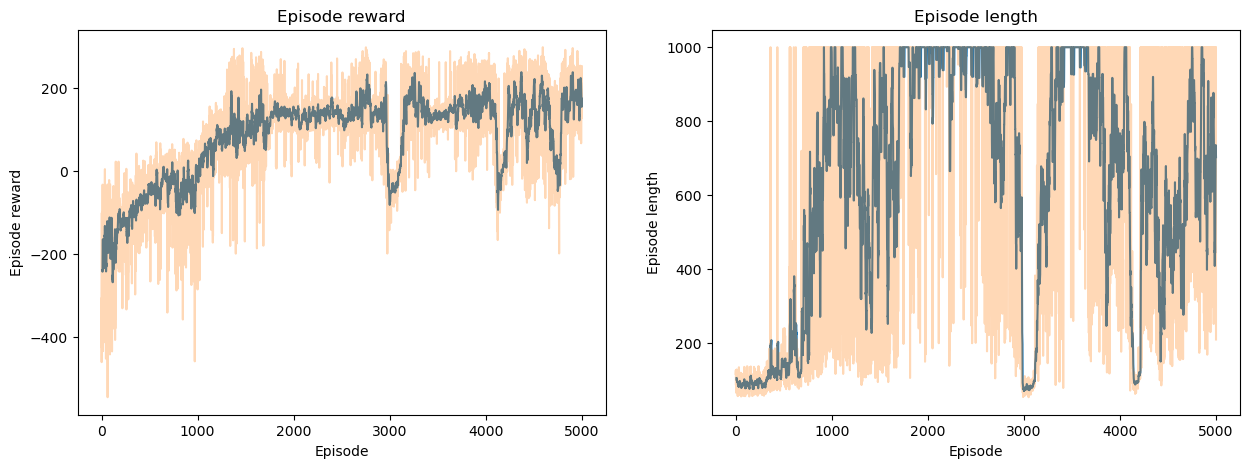

In [7]:
# Initialize the environment.
env_name = "LunarLander-v2"
env = gym.make(env_name)
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]
# print("Action size:", action_size, "State size:", state_size)

# Hyperparameters
lr = 5e-4
gamma = 0.99
hidden_dim = 256
episodes = 5000
stats_every = 100 

# Initialize the policy agent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
date = datetime.now().strftime("%Y%m%d-%H%M%S")
baseline = True
agent_name = "REINFORCE" + ("_BASELINE" if baseline else "")
agent_name = agent_name + "_" + date
agent = REINFORCEAgent(state_dim, action_dim, hidden_dim, lr, gamma, baseline=baseline, device=device)

name_exercise = "lunarlander-baseline"

# Train the agent
train_agent(
    agent=agent,
    agent_name=agent_name,
    env=env,
    env_name=env_name,
    episodes=episodes,
    stats_every=stats_every,
    name_exercise=name_exercise,
    wb=True,
    device=device
)

---
# Exercise 3.2: Solving Cartpole and Lunar Lander with `Deep Q-Learning` (harder)

On policy Deep Reinforcement Learning tends to be **very unstable**. Write an implementation (or adapt an existing one) of `Deep Q-Learning` to solve our two environments (Cartpole and Lunar Lander). To do this you will need to implement a **Replay Buffer** and use a second, slow-moving **target Q-Network** to stabilize learning.

In [27]:
# TRAIN AGENT
def train_agent(agent, agent_name, env, env_name, episodes, epsilon, stats_every=100, name_exercise=None, wb=True, device="cuda"):
    # Initialize wandb
    if wb: wandb_init(agent, agent_name, env_name, episodes, device=device)

    # Track episode rewards in a list
    scores = []

    # Loop over the episodes
    for episode in tqdm(range(1, episodes+1), desc="Episodes", unit="episode", leave=True):
        # Generate the episode
        (state, info) = env.reset()
        tot_reward = 0
        loss = 0

        # Run the episode  
        for step in count():
            # Select an action
            action = agent.act(state, epsilon.get())

            # Do the action in the environment
            next_state, reward, term, trunc, _ = env.step(action)

            # Update the total reward
            tot_reward += reward
            done = term or trunc 
            
            # Step the agent
            loss += agent.step(state, action, reward, next_state, done)

            state = next_state

            # If the episode is done, break
            if done: 
                break

        # Save the stats and log to wandb
        scores.append((episode, tot_reward, step))
        if wb: wandb.log({"train/total_reward": tot_reward, "train/episode_length": step, "train/loss": loss}, step=episode)

        # Update epsilon
        epsilon.update()

        # Print stats
        if not episode % stats_every:
            # Evaluate the agent
            total_reward = np.mean(scores[-stats_every:], axis=0)[1]
            total_length = np.mean(scores[-stats_every:], axis=0)[2]
            
            # Print stats and log to wandb
            print(f"Episode {episode}, Time steps: {step}, Total reward: {total_reward:.1f}, Episode length: {total_length:.1f}, Epsilon: {epsilon.get():.2f}, Loss: {loss:.3f}")
            if wb: wandb.log({"eval/time_steps": step, "eval/total_reward": total_reward, "eval/episode_length": total_length, "eval/epsilon": epsilon.get(),"eval/loss": loss}, step=episode)

            # stopping condition for training if agent reaches the amount of reward
            if np.mean(scores[-stats_every:], axis=0)[1] >= 200.00:
                print("Stopping at episode {} with average rewards of {} in last {} episodes".
                    format(episode, np.mean(scores[-stats_every:],axis=0)[1], stats_every))
                torch.save(agent.train_net.state_dict(), f"model_states/{agent_name}_episode_{episode}.pth")
                if name_exercise is not None:
                    show_video_of_model(agent, env_name, name_exercise)
                    # show_video(env_name, name_exercise)
                break 
    
    # Close the environment
    env.close()

    # Finish wandb
    if wb:
        wandb.finish()
    
    # Plot 
    plot_stats(scores)

    return scores


def show_video(env_name, name_exercise = None):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = f'video/{env_name}/{name_exercise}-episode-0.mp4'
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        name_exercise.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
        

def show_video_of_model(agent, env_name, name_exercise, file_path=None):
    if file_path is not None:
        agent.train_net.load_state_dict(torch.load(file_path))

    env = gym.make(env_name, render_mode="rgb_array")
    env = gym.wrappers.RecordVideo(env=env, video_folder=f"video/{env_name}", name_prefix=name_exercise, disable_logger=True)

    obs, info = env.reset()

    env.start_video_recorder()

    for _ in count():
        action = agent.act(obs, 0)
        obs, rew, term, trunc, info = env.step(action)
        env.render()

        if term or trunc:
            obs, info = env.reset()
            break
            
    env.close_video_recorder()

    env.close()


def plot_stats(stats_rewards_list):
    # plot stats
    def get_running_stat(stat, stat_len):
        cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
        return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

    episode, r, l = np.array(stats_rewards_list).T
    cum_r = get_running_stat(r, 10)
    cum_l = get_running_stat(l, 10)

    # Plots
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].set_title("Episode reward")
    ax[0].plot(episode[-len(cum_r):], cum_r)
    ax[0].plot(episode, r, alpha=0.3)
    ax[0].set_xlabel("Episode")
    ax[0].set_ylabel("Episode reward")

    ax[1].set_title("Episode length")
    ax[1].plot(episode[-len(cum_l):], cum_l)
    ax[1].plot(episode, l, alpha=0.3)
    ax[1].set_xlabel("Episode")
    ax[1].set_ylabel("Episode length")
    

# Function to initialize wandb
def wandb_init(agent, algorithm, env, episodes, device="cuda", project="DLA Assigment 3"):
    # Initialize wandb
    wandb.init(
        project=project,
        name=algorithm,
        # Track hyperparameters and run metadata
        config={
            "algorithm": algorithm,
            "environment": env,
            "episodes": episodes,
            "learning_rate": agent.lr,
            "gamma": agent.gamma,
            "optimizer": "Adam",
            "device": device.type
        }
    )


class Epsilon():
    def __init__(self, start=1.0, end=0.01, decay=0.995):
        self.start = start
        self.end = end
        self.decay = decay
        self.epsilon = start

    def update(self):
        self.epsilon = max(self.end, self.epsilon*self.decay)

    def get(self):
        return self.epsilon

In [3]:
# Replay Buffer
class ReplayBuffer():
    def __init__(self, buffer_size, batch_size):
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def push(self, state, action, reward, next_state, done):
        # Add a new experience to the buffer
        self.buffer.append(self.experience(state, action, reward, next_state, done))

    def sample(self, batch_size):
        # Randomly sample a batch of experiences from the buffer
        s = random.sample(self.buffer, batch_size)
        states      = torch.from_numpy(np.vstack([e.state for e in s])).float().to(device)
        actions     = torch.from_numpy(np.vstack([e.action for e in s])).long().to(device)
        rewards     = torch.from_numpy(np.vstack([e.reward for e in s])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in s])).float().to(device)
        dones       = torch.from_numpy(np.vstack([e.done for e in s])).float().to(device)
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        # Return the current size of the buffer
        return len(self.buffer)

In [4]:
# Create a DQNetwork where the output is the Q value for each action
class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )
        
    def forward(self, s):
        return self.net(s)

In [5]:
# DQN Agent
class DQNAgent():
    def __init__(self, state_size, action_size, hidden_size, lr, gamma, buffer_size, batch_size, tau, update_every, mse_loss=False, device='cuda'):
        # Parameters
        self.action_size = action_size
        self.lr = lr
        self.gamma = gamma

        # Networks
        self.train_net = DQN(state_size, action_size, hidden_size).to(device)
        self.target_net = DQN(state_size, action_size, hidden_size).to(device)
        self.target_net.load_state_dict(self.train_net.state_dict())

        # Update parameters
        self.optimizer = optim.Adam(self.train_net.parameters(), lr=lr)
        self.mse_loss = mse_loss
        self.tau = tau
        self.steps = 0
        self.update_every = update_every
        
        # Replay buffer
        self.memory = ReplayBuffer(buffer_size=buffer_size, batch_size=batch_size)

        
    def act(self, state, epsilon):
        # Epsilon greedy policy
        if np.random.rand() <= epsilon:
            return np.random.choice(self.action_size)
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                q_values = self.train_net(state)
                return torch.argmax(q_values).item()
            
    
    def step(self, state, action, reward, next_state, done):
        # Add the experience to the replay buffer and learn
        self.memory.push(state, action, reward, next_state, done)
        self.steps = (self.steps + 1) % self.update_every

        # Learn
        loss = 0
        if self.steps == 0:
            if len(self.memory) > self.memory.batch_size:
                experience = self.memory.sample(self.memory.batch_size)
                loss = self.train(experience)
        return loss
            

    def train(self, experience):
        # Get values from the experience
        states, actions, rewards, next_states, dones = experience

        # Compute the Q values from the train network
        train_q_values = self.train_net(states).gather(1, actions)

        # Compute the Q values from the target network
        with torch.no_grad():
            target_q_values = rewards + self.gamma * (1-dones) * torch.max(self.target_net(next_states), dim=1)[0].view(-1, 1)

        # Compute the loss between the train and target Q values
        if self.mse_loss:
            # In this case we use the MSE loss
            loss = F.mse_loss(train_q_values, target_q_values)
        else:
            # In this case we use the smooth L1 loss (similar to the Huber loss)
            loss = F.smooth_l1_loss(train_q_values, target_q_values)

        # Optimize the network
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.train_net.parameters(), 100)
        self.optimizer.step()

        # Update the target network
        self.update_target_net()

        return loss.detach().cpu().numpy()
    
    
    def update_target_net(self):
        # Update the target network
        # θ_target = τ*θ_local + (1 - τ)*θ_target
        for target_param, train_param in zip(self.target_net.parameters(), self.train_net.parameters()):
            target_param.data.copy_(self.tau * train_param.data + (1.0 - self.tau) * target_param.data)


### Cartpole Environment

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lorebaia. Use `wandb login --relogin` to force relogin


Episodes:  10%|▉         | 99/1000 [00:03<00:40, 22.50episode/s]

Episode 100, Time steps: 16, Total reward: 20.4, Episode length: 19.4, Epsilon: 0.61, Loss: 9.256


Episodes:  20%|█▉        | 199/1000 [00:25<05:55,  2.25episode/s]

Episode 200, Time steps: 282, Total reward: 117.2, Episode length: 116.2, Epsilon: 0.37, Loss: 37.488


Episodes:  30%|██▉       | 299/1000 [01:16<04:55,  2.37episode/s]

Episode 300, Time steps: 335, Total reward: 285.4, Episode length: 284.4, Epsilon: 0.22, Loss: 4.785
Stopping at episode 300 with average rewards of 285.38 in last 100 episodes


c:\Users\loreb\miniconda3\envs\DLA\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\loreb\Documents\Projects\DLA\Lab3\video\CartPole-v1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Could not find video


Episodes:  30%|██▉       | 299/1000 [01:19<03:05,  3.78episode/s]


eval/episode_length,▁▄█
eval/epsilon,█▄▁
eval/loss,▂█▁
eval/time_steps,▁▇█
eval/total_reward,▁▄█
train/episode_length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▃▃▂▄▁▇▆█▆▇▄▆▅▆▇▅▃▆▆▅▇▆
train/loss,▁▂▁▁▂▂▃▃▂▂▂▂▂▂▂▄▂▂▆▅▃▅▁█▆▇▅▅▃▂▂▃▂▂▁▂▁▁▁▁
train/total_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▃▃▂▄▁▇▆█▆▇▄▆▅▆▇▅▃▆▆▅▇▆
eval/episode_length,284.38
eval/epsilon,0.22229
eval/loss,4.78507


[(1, 10.0, 9),
 (2, 21.0, 20),
 (3, 33.0, 32),
 (4, 17.0, 16),
 (5, 17.0, 16),
 (6, 12.0, 11),
 (7, 30.0, 29),
 (8, 28.0, 27),
 (9, 62.0, 61),
 (10, 28.0, 27),
 (11, 48.0, 47),
 (12, 16.0, 15),
 (13, 18.0, 17),
 (14, 19.0, 18),
 (15, 10.0, 9),
 (16, 16.0, 15),
 (17, 14.0, 13),
 (18, 12.0, 11),
 (19, 14.0, 13),
 (20, 18.0, 17),
 (21, 44.0, 43),
 (22, 22.0, 21),
 (23, 18.0, 17),
 (24, 11.0, 10),
 (25, 13.0, 12),
 (26, 33.0, 32),
 (27, 21.0, 20),
 (28, 15.0, 14),
 (29, 12.0, 11),
 (30, 18.0, 17),
 (31, 22.0, 21),
 (32, 19.0, 18),
 (33, 11.0, 10),
 (34, 17.0, 16),
 (35, 12.0, 11),
 (36, 12.0, 11),
 (37, 22.0, 21),
 (38, 17.0, 16),
 (39, 10.0, 9),
 (40, 12.0, 11),
 (41, 16.0, 15),
 (42, 13.0, 12),
 (43, 36.0, 35),
 (44, 10.0, 9),
 (45, 34.0, 33),
 (46, 12.0, 11),
 (47, 13.0, 12),
 (48, 16.0, 15),
 (49, 10.0, 9),
 (50, 16.0, 15),
 (51, 42.0, 41),
 (52, 13.0, 12),
 (53, 9.0, 8),
 (54, 14.0, 13),
 (55, 14.0, 13),
 (56, 22.0, 21),
 (57, 14.0, 13),
 (58, 34.0, 33),
 (59, 17.0, 16),
 (60, 14.0, 1

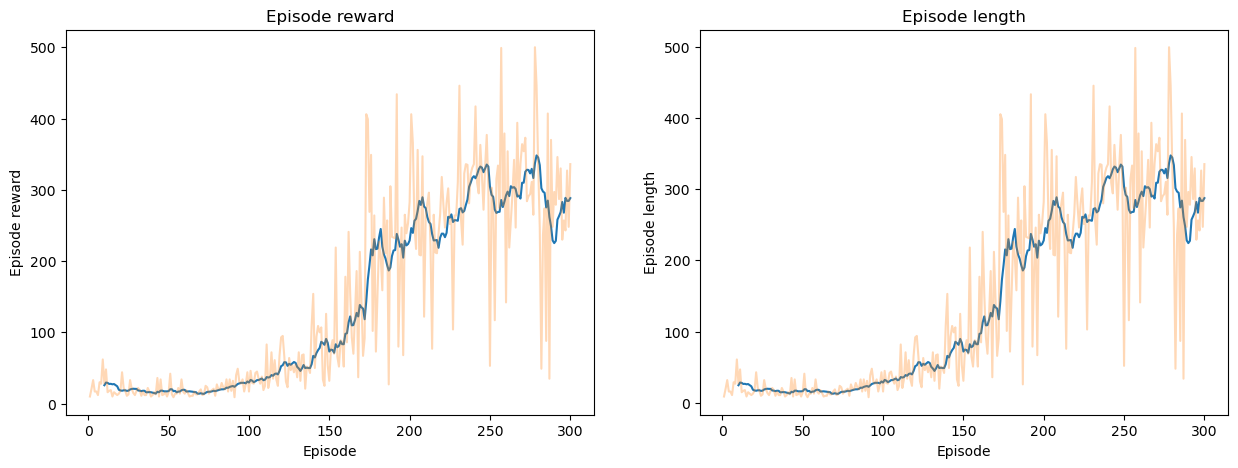

In [29]:
# Initialize the environment.
env_name = "CartPole-v1"
env = gym.make(env_name)
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]
# print("Action size:", action_size, "State size:", state_size)

# Hyperparameters
episodes = 1000
stats_every = 100
epsilon = Epsilon(start=1.0, end=0.01, decay=0.995)

# Network parameters
lr = 5e-4
gamma = 0.9
hidden_dim = 64
update_every = 4
tau = 1

# Initialize the Replay Buffer
buffer_size = 15000
batch_size = 64
buffer = ReplayBuffer(buffer_size, batch_size)

# Initialize the DQN agent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
date = datetime.now().strftime("%Y%m%d-%H%M%S")
agent_name = "DQN"
agent_name = agent_name + "_" + date
agent = DQNAgent(state_dim, action_dim, hidden_dim, lr, gamma, buffer_size, batch_size, tau, update_every, mse_loss=True, device=device)

name_exercise = "cartpole-dqn"

# Train the agent
train_agent(
    agent=agent,
    agent_name=agent_name,
    env=env,
    env_name=env_name,
    episodes=episodes,
    epsilon=epsilon,
    stats_every=stats_every,
    name_exercise=name_exercise,
    wb=True,
    device=device
)

### Lunar Lander Environment

Episodes:   5%|▍         | 99/2000 [00:16<08:01,  3.95episode/s]

Episode 100, Time steps: 110, Total reward: -141.7, Episode length: 114.7, Epsilon: 0.61, Loss: 31.789


Episodes:  10%|▉         | 199/2000 [01:31<1:00:30,  2.02s/episode]

Episode 200, Time steps: 534, Total reward: -32.4, Episode length: 381.4, Epsilon: 0.37, Loss: 163.847


Episodes:  15%|█▍        | 299/2000 [04:30<59:04,  2.08s/episode]  

Episode 300, Time steps: 999, Total reward: -8.5, Episode length: 807.7, Epsilon: 0.22, Loss: 240.817


Episodes:  20%|█▉        | 399/2000 [07:31<39:01,  1.46s/episode]  

Episode 400, Time steps: 697, Total reward: 142.3, Episode length: 751.3, Epsilon: 0.13, Loss: 155.423


Episodes:  25%|██▍       | 499/2000 [09:45<31:05,  1.24s/episode]

Episode 500, Time steps: 373, Total reward: 213.7, Episode length: 539.7, Epsilon: 0.08, Loss: 52.141
Stopping at episode 500 with average rewards of 213.6603113423288 in last 100 episodes


c:\Users\loreb\miniconda3\envs\DLA\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\loreb\Documents\Projects\DLA\Lab3\video\LunarLander-v2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Could not find video


Episodes:  25%|██▍       | 499/2000 [09:48<29:30,  1.18s/episode]


eval/episode_length,▁▄█▇▅
eval/epsilon,█▅▃▂▁
eval/loss,▁▅█▅▂
eval/time_steps,▁▄█▆▃
eval/total_reward,▁▃▄▇█
train/episode_length,▁▁▁▁▁▁▁▂██▂▁▁▂█▃█▂███▃█▁▄▆███▅▇▅▅▄▅█▄▆▃▄
train/loss,▂▂▂▁▁▁▁▂██▂▁▁▂█▃▇▂▇▆▆▃▆▁▃▄▅▅▅▃▅▃▃▂▃▄▂▃▂▂
train/total_reward,▁▄▁▃▃▃▄▃▅▅▄▄▄▄▆▄▅▄▃▅▄▃▅▄▇▇▇▇▆█▆█▇██▇▇██▇
eval/episode_length,539.71
eval/epsilon,0.08157
eval/loss,52.14068


[(1, -161.08856318703394, 114),
 (2, -370.2636396416763, 103),
 (3, -230.6496604954022, 98),
 (4, -317.9460979275017, 131),
 (5, -166.15730538405555, 100),
 (6, -386.4679531268638, 103),
 (7, -254.37194033267664, 89),
 (8, -84.70698811333726, 64),
 (9, -108.77820104942396, 106),
 (10, -140.74100567589937, 92),
 (11, -98.95319597716431, 90),
 (12, -68.32695366947479, 94),
 (13, -372.4738914437076, 146),
 (14, -90.50611967415975, 81),
 (15, -194.9838973045728, 78),
 (16, -91.55128662762709, 150),
 (17, -114.623092416481, 85),
 (18, -258.3391565211663, 102),
 (19, -78.00672575183873, 110),
 (20, -284.9067839852141, 96),
 (21, -222.28044256821914, 126),
 (22, -104.00813320885202, 65),
 (23, -103.15553533389601, 78),
 (24, 39.35313880050211, 82),
 (25, -215.18102170675158, 132),
 (26, 42.95232073453491, 97),
 (27, -85.25748938571611, 117),
 (28, -316.9768014099243, 127),
 (29, -147.2300389261374, 107),
 (30, -89.94826193459464, 76),
 (31, -69.5009923529076, 156),
 (32, -218.64472813927307, 

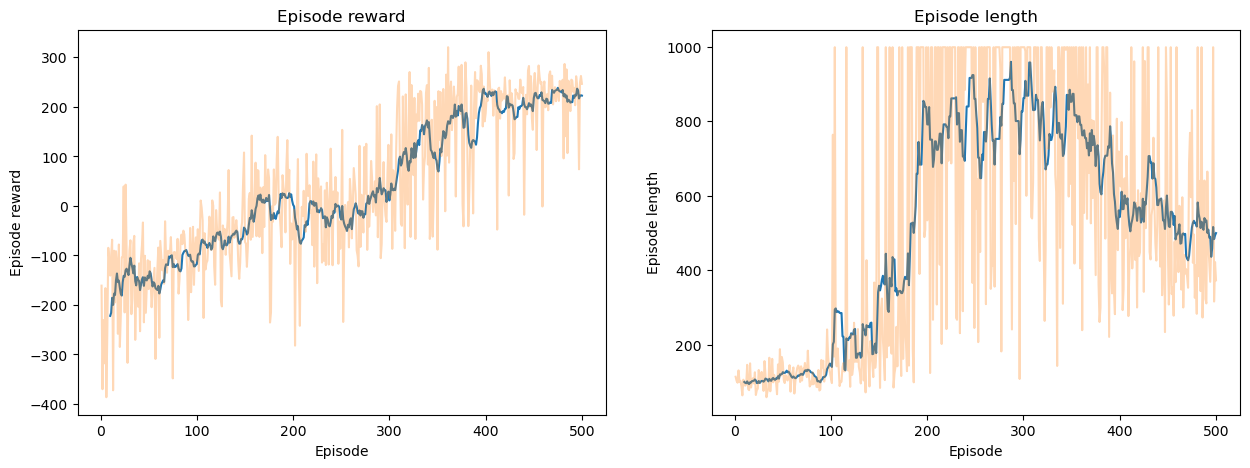

In [32]:
# Initialize the environment.
env_name = "LunarLander-v2"
env = gym.make(env_name)
name_exercise = None
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]
# print("Action size:", action_size, "State size:", state_size)

# Hyperparameters
episodes = 2000
stats_every = 100
epsilon = Epsilon(start=1.0, end=0.01, decay=0.995)

# Network parameters
lr = 5e-4
gamma = 0.99
hidden_dim = 128
update_every = 4
tau = 1e-3

# Initialize the Replay Buffer
buffer_size = 200000
batch_size = 128
buffer = ReplayBuffer(buffer_size, batch_size)

# Initialize the DQN agent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
date = datetime.now().strftime("%Y%m%d-%H%M%S")
agent_name = "DQN"
agent_name = agent_name + "_" + date
agent = DQNAgent(state_dim, action_dim, hidden_dim, lr, gamma, buffer_size, batch_size, tau, update_every, device=device)

name_exercise = "lunarlander-dqn"

# Train the agent
train_agent(
    agent=agent,
    agent_name=agent_name,
    env=env,
    env_name=env_name,
    episodes=episodes,
    epsilon=epsilon,
    stats_every=stats_every,
    name_exercise=name_exercise,
    wb=True,
    device=device
)

---
# Exercise 3.3: Solving the OpenAI CarRacing environment (hardest) 

Use `Deep Q-Learning` -- or even better, an off-the-shelf implementation of **Proximal Policy Optimization (PPO)** -- to train an agent to solve the [OpenAI CarRacing](https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN) environment. This will be the most *fun*, but also the most *difficult*. Some tips:

1. Make sure you use the `continuous=False` argument to the environment constructor. This ensures that the action space is **discrete** (we haven't seen how to work with continuous action spaces).
2. Your Q-Network will need to be a CNN. A simple one should do, with two convolutional + maxpool layers, folowed by a two dense layers. You will **definitely** want to use a GPU to train your agents.
3. The observation space of the environment is a single **color image** (a single frame of the game). Most implementations stack multiple frames (e.g. 3) after converting them to grayscale images as an observation.

In [2]:
import cv2

class ImageEnv(gym.Wrapper):
    def __init__(self, env, skip_frames=4, stack_frames=4, initial_no_op=50, **kwargs):
        super(ImageEnv, self).__init__(env, **kwargs)
        self.initial_no_op = initial_no_op
        self.skip_frames = skip_frames
        self.stack_frames = stack_frames
        self.max_episode_steps = self.env._max_episode_steps
    
    def reset(self):
        # Reset the original environment.
        s, info = self.env.reset()

        # Do nothing for the next `self.initial_no_op` steps
        for i in range(self.initial_no_op):
            s, r, terminated, truncated, info = self.env.step(0)
        
        # Convert a frame to 84 X 84 gray scale one
        s = cv2.cvtColor(s[:84, 6:90], cv2.COLOR_RGB2GRAY) / 255.0

        # The initial observation is simply a copy of the frame `s`
        self.stacked_state = np.tile(s, (self.stack_frames, 1, 1))  # [4, 84, 84]
        return self.stacked_state, info
    
    def step(self, action):
        # We take an action for self.skip_frames steps
        reward = 0
        for _ in range(self.skip_frames):
            s, r, terminated, truncated, info = self.env.step(action)
            reward += r
            if terminated or truncated:
                break

        # Convert a frame to 84 X 84 gray scale one
        s = cv2.cvtColor(s[:84, 6:90], cv2.COLOR_RGB2GRAY) / 255.0

        # Push the current frame `s` at the end of self.stacked_state
        self.stacked_state = np.concatenate((self.stacked_state[1:], s[np.newaxis]), axis=0)

        return self.stacked_state, reward, terminated, truncated, info

### DQN Implementation

In [3]:
# TRAIN AGENT
def train_agent(agent, agent_name, env, env_name, episodes, epsilon, stats_every=100, name_exercise=None, wb=True, device="cuda"):
    # Initialize wandb
    if wb: wandb_init(agent, agent_name, env_name, episodes, device=device)

    # Track episode rewards in a list
    scores = []

    # Loop over the episodes
    for episode in tqdm(range(1, episodes+1), desc="Episodes", unit="episode", leave=True):
        # Generate the episode
        (state, info) = env.reset()
        tot_reward = 0
        loss = 0

        # Run the episode  
        for step in count():
            # Select an action
            action = agent.act(state, epsilon.get())

            # Do the action in the environment
            next_state, reward, term, trunc, _ = env.step(action)

            # Update the total reward
            tot_reward += reward
            done = term or trunc 
            
            # Step the agent
            loss += agent.step(state, action, reward, next_state, done)

            state = next_state

            # If the episode is done, break
            if done: 
                break

        # Save the stats and log to wandb
        scores.append((episode, tot_reward, step))
        if wb: wandb.log({"train/total_reward": tot_reward, "train/episode_length": step, "train/loss": loss}, step=episode)

        # Update epsilon
        epsilon.update()

        # Print stats
        if not episode % stats_every:
            # Evaluate the agent
            total_reward = np.mean(scores[-stats_every:], axis=0)[1]
            total_length = np.mean(scores[-stats_every:], axis=0)[2]
            
            # Print stats and log to wandb
            print(f"Episode {episode}, Time steps: {step}, Total reward: {total_reward:.1f}, Episode length: {total_length:.1f}, Epsilon: {epsilon.get():.2f}, Loss: {loss:.3f}")
            if wb: wandb.log({"eval/time_steps": step, "eval/total_reward": total_reward, "eval/episode_length": total_length, "eval/epsilon": epsilon.get(),"eval/loss": loss}, step=episode)

            # stopping condition for training if agent reaches the amount of reward
            if np.mean(scores[-stats_every:], axis=0)[1] >= 200.00 or episode == episodes:
                print("Stopping at episode {} with average rewards of {} in last {} episodes".
                    format(episode, np.mean(scores[-stats_every:],axis=0)[1], stats_every))
                torch.save(agent.train_net.state_dict(), f"model_states/{agent_name}_episode_{episode}.pth")
                if name_exercise is not None:
                    show_video_of_model(agent, env_name, name_exercise)
                    # show_video(env_name, name_exercise)
                break 
    
    # Close the environment
    env.close()

    # Finish wandb
    if wb:
        wandb.finish()
    
    # Plot 
    plot_stats(scores)

    return scores


def show_video(env_name, name_exercise = None):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = f'video/{env_name}/{name_exercise}-episode-0.mp4'
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        name_exercise.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
        

def show_video_of_model(agent, env_name, name_exercise, file_path=None):
    if file_path is not None:
        agent.train_net.load_state_dict(torch.load(file_path))

    env = gym.make(env_name, render_mode="rgb_array")
    env = gym.wrappers.RecordVideo(env=env, video_folder=f"video/{env_name}", name_prefix=name_exercise, disable_logger=True)

    obs, info = env.reset()

    env.start_video_recorder()

    for _ in count():
        action = agent.act(obs, 0)
        obs, rew, term, trunc, info = env.step(action)
        env.render()

        if term or trunc:
            obs, info = env.reset()
            break
            
    env.close_video_recorder()

    env.close()


def animate(imgs, video_name, _return=True):
    import cv2
    import os
    import string
    import random
    
    if video_name is None:
        video_name = ''.join(random.choice(string.ascii_letters) for i in range(18)) + '.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width, height))
    
    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()
    if _return:
        from IPython.display import Video
        return Video(video_name)


def plot_stats(stats_rewards_list):
    # plot stats
    def get_running_stat(stat, stat_len):
        cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
        return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

    episode, r, l = np.array(stats_rewards_list).T
    cum_r = get_running_stat(r, 10)
    cum_l = get_running_stat(l, 10)

    # Plots
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].set_title("Episode reward")
    ax[0].plot(episode[-len(cum_r):], cum_r)
    ax[0].plot(episode, r, alpha=0.3)
    ax[0].set_xlabel("Episode")
    ax[0].set_ylabel("Episode reward")

    ax[1].set_title("Episode length")
    ax[1].plot(episode[-len(cum_l):], cum_l)
    ax[1].plot(episode, l, alpha=0.3)
    ax[1].set_xlabel("Episode")
    ax[1].set_ylabel("Episode length")
    

# Function to initialize wandb
def wandb_init(agent, algorithm, env, episodes, device="cuda", project="DLA Assigment 3"):
    # Initialize wandb
    wandb.init(
        project=project,
        name=algorithm,
        # Track hyperparameters and run metadata
        config={
            "algorithm": algorithm,
            "environment": env,
            "episodes": episodes,
            "learning_rate": agent.lr,
            "gamma": agent.gamma,
            "optimizer": "Adam",
            "device": device.type
        }
    )


class Epsilon():
    def __init__(self, start=1.0, end=0.01, decay=0.995):
        self.start = start
        self.end = end
        self.decay = decay
        self.epsilon = start

    def update(self):
        self.epsilon = max(self.end, self.epsilon*self.decay)

    def get(self):
        return self.epsilon

In [4]:
# Replay Buffer
class ReplayBuffer():
    def __init__(self, buffer_size, state_dim, action_dim, batch_size):
        self.s = np.zeros((buffer_size, *state_dim), dtype=np.float32)
        self.a = np.zeros((buffer_size, *action_dim), dtype=np.int64)
        self.r = np.zeros((buffer_size, 1), dtype=np.float32)
        self.s_prime = np.zeros((buffer_size, *state_dim), dtype=np.float32)
        self.terminated = np.zeros((buffer_size, 1), dtype=np.float32)

        self.ptr = 0
        self.size = 0
        self.buffer_size = buffer_size
        self.batch_size = batch_size

    def update(self, s, a, r, s_prime, terminated):
        self.s[self.ptr] = s
        self.a[self.ptr] = a
        self.r[self.ptr] = r
        self.s_prime[self.ptr] = s_prime
        self.terminated[self.ptr] = terminated
        
        self.ptr = (self.ptr + 1) % self.buffer_size
        self.size = min(self.size + 1, self.buffer_size)

    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, batch_size)
        return (
            torch.FloatTensor(self.s[ind]),
            torch.FloatTensor(self.a[ind]),
            torch.FloatTensor(self.r[ind]),
            torch.FloatTensor(self.s_prime[ind]),
            torch.FloatTensor(self.terminated[ind]), 
        )
    
    def __len__(self):
        # Return the current size of the buffer
        return self.size

In [5]:
# Create a DQNetwork where the output is the Q value for each action
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(state_dim, hidden_dim, kernel_size=8, stride=4),  
            nn.Conv2d(hidden_dim, hidden_dim*2, kernel_size=4, stride=2),  
            nn.Flatten(),
            nn.Linear(hidden_dim*2 * 9 * 9, 256),
            nn.Linear(256, action_dim),
        )

    def forward(self, s):
        return self.net(s)
        
    def forward(self, s):
        return self.net(s)

In [7]:
# DQN Agent
class DQNAgent():
    def __init__(self, state_size, action_size, hidden_size, lr, gamma, buffer_size, batch_size, tau, update_every, mse_loss=False, device='cuda'):
        # Parameters
        self.action_size = action_size
        self.lr = lr
        self.gamma = gamma

        # Networks
        state_channels = state_size[0]
        self.train_net = DQN(state_channels, action_size, hidden_size).to(device)
        self.target_net = DQN(state_channels, action_size, hidden_size).to(device)
        self.target_net.load_state_dict(self.train_net.state_dict())

        # Update parameters
        self.optimizer = optim.Adam(self.train_net.parameters(), lr=lr)
        self.mse_loss = mse_loss
        self.tau = tau
        self.steps = 0
        self.update_every = update_every
        
        # Replay buffer
        self.memory = ReplayBuffer(buffer_size=buffer_size, state_dim=state_size, action_dim=(1,), batch_size=batch_size)

        
    def act(self, state, epsilon):
        # Epsilon greedy policy
        if np.random.rand() <= epsilon:
            return np.random.choice(self.action_size)
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = self.train_net(state)
                return torch.argmax(q_values).item()
            
    
    def step(self, state, action, reward, next_state, done):
        # Add the experience to the replay buffer and learn
        self.memory.update(state, action, reward, next_state, done)
        self.steps = (self.steps + 1) % self.update_every

        # Learn
        loss = 0
        if self.steps == 0:
            if len(self.memory) > self.memory.batch_size:
                s, a, r, n_s, d = map(lambda x: x.to(device), self.memory.sample(self.memory.batch_size))
                loss = self.train(s, a, r, n_s, d)
        return loss
            

    def train(self, states, actions, rewards, next_states, dones):
        # Compute the Q values from the train network
        train_q_values = self.train_net(states).gather(1, actions.long())

        # Compute the Q values from the target network
        with torch.no_grad():
            next_q = self.target_net(next_states).detach()
            target_q_values = rewards + self.gamma * (1-dones) * next_q.max(dim=1, keepdim=True).values

        # Compute the loss between the train and target Q values
        if self.mse_loss:
            # In this case we use the MSE loss
            loss = F.mse_loss(train_q_values, target_q_values)
        else:
            # In this case we use the smooth L1 loss (similar to the Huber loss)
            loss = F.smooth_l1_loss(train_q_values, target_q_values)

        # Optimize the network
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.train_net.parameters(), 100)
        self.optimizer.step()

        # Update the target network
        self.update_target_net()

        return loss.detach().cpu().numpy()
    
    
    def update_target_net(self):
        # Update the target network
        # θ_target = τ*θ_local + (1 - τ)*θ_target
        for target_param, train_param in zip(self.target_net.parameters(), self.train_net.parameters()):
            target_param.data.copy_(self.tau * train_param.data + (1.0 - self.tau) * target_param.data)


In [8]:
# Initialize the environment.
env_name = "CarRacing-v2"
env = ImageEnv(gym.make(env_name, continuous=False))
action_dim = env.action_space.n
state_dim = (4, 84, 84)

# Hyperparameters
episodes = 2000
stats_every = 20
epsilon = Epsilon(start=1.0, end=0.01, decay=0.995)

# Network parameters
lr = 0.003
gamma = 0.99
hidden_dim = 16
update_every = 5
tau = 1

# Initialize the Replay Buffer
buffer_size = 10000
batch_size = 32

# Initialize the DQN agent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
date = datetime.now().strftime("%Y%m%d-%H%M%S")
agent_name = "DQN"
agent_name = agent_name + "_" + date
agent = DQNAgent(state_dim, action_dim, hidden_dim, lr, gamma, buffer_size, batch_size, tau, update_every, mse_loss=True, device=device)

name_exercise = "carracing-dqn"

# Train the agent
train_agent(
    agent=agent,
    agent_name=agent_name,
    env=env,
    env_name=env_name,
    episodes=episodes,
    epsilon=epsilon,
    stats_every=stats_every,
    name_exercise=name_exercise,
    wb=True,
    device=device
)

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lorebaia. Use `wandb login --relogin` to force relogin


Episodes:   0%|          | 0/2000 [00:00<?, ?episode/s]c:\Users\loreb\miniconda3\envs\DLA\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Episodes:   1%|          | 19/2000 [04:10<7:13:36, 13.13s/episode]

Episode 20, Time steps: 237, Total reward: -52.6, Episode length: 237.0, Epsilon: 0.90, Loss: 2689.561


Episodes:   2%|▏         | 39/2000 [08:27<6:52:07, 12.61s/episode]

Episode 40, Time steps: 237, Total reward: -47.4, Episode length: 237.0, Epsilon: 0.82, Loss: 226.795


Episodes:   3%|▎         | 59/2000 [12:39<7:15:29, 13.46s/episode]

Episode 60, Time steps: 237, Total reward: -44.6, Episode length: 237.0, Epsilon: 0.74, Loss: 35.407


Episodes:   4%|▍         | 79/2000 [16:57<6:42:30, 12.57s/episode]

Episode 80, Time steps: 237, Total reward: -46.9, Episode length: 237.0, Epsilon: 0.67, Loss: 37.062


Episodes:   5%|▍         | 99/2000 [21:12<7:01:13, 13.29s/episode]

Episode 100, Time steps: 237, Total reward: -43.3, Episode length: 237.0, Epsilon: 0.61, Loss: 33.502


Episodes:   6%|▌         | 119/2000 [25:34<6:35:39, 12.62s/episode]

Episode 120, Time steps: 237, Total reward: -33.8, Episode length: 237.0, Epsilon: 0.55, Loss: 127.140


Episodes:   7%|▋         | 139/2000 [30:01<6:45:02, 13.06s/episode]

Episode 140, Time steps: 237, Total reward: -52.4, Episode length: 237.0, Epsilon: 0.50, Loss: 1226585703.547


Episodes:   8%|▊         | 159/2000 [34:18<6:30:12, 12.72s/episode]

Episode 160, Time steps: 237, Total reward: -56.7, Episode length: 234.0, Epsilon: 0.45, Loss: 55617061.714


Episodes:   9%|▉         | 179/2000 [38:20<6:26:24, 12.73s/episode]

Episode 180, Time steps: 237, Total reward: -48.2, Episode length: 226.6, Epsilon: 0.41, Loss: 13066292.282


Episodes:  10%|▉         | 199/2000 [42:33<6:16:06, 12.53s/episode]

Episode 200, Time steps: 237, Total reward: -46.3, Episode length: 236.4, Epsilon: 0.37, Loss: 4301710.216


Episodes:  11%|█         | 219/2000 [46:47<6:15:02, 12.63s/episode]

Episode 220, Time steps: 237, Total reward: -37.9, Episode length: 237.0, Epsilon: 0.33, Loss: 526597.487


Episodes:  12%|█▏        | 239/2000 [50:51<6:12:40, 12.70s/episode]

Episode 240, Time steps: 237, Total reward: -42.2, Episode length: 227.4, Epsilon: 0.30, Loss: 516842.357


Episodes:  13%|█▎        | 259/2000 [54:52<5:09:25, 10.66s/episode]

Episode 260, Time steps: 237, Total reward: -54.4, Episode length: 227.6, Epsilon: 0.27, Loss: 40956.924


Episodes:  14%|█▍        | 279/2000 [59:05<6:02:07, 12.62s/episode]

Episode 280, Time steps: 237, Total reward: -53.9, Episode length: 237.0, Epsilon: 0.25, Loss: 16379.127


Episodes:  15%|█▍        | 299/2000 [1:03:14<6:05:08, 12.88s/episode]

Episode 300, Time steps: 237, Total reward: -40.7, Episode length: 230.8, Epsilon: 0.22, Loss: 4087.069


Episodes:  16%|█▌        | 319/2000 [1:07:17<4:55:45, 10.56s/episode]

Episode 320, Time steps: 237, Total reward: -43.9, Episode length: 225.2, Epsilon: 0.20, Loss: 5643.338


Episodes:  17%|█▋        | 339/2000 [1:11:25<4:55:17, 10.67s/episode]

Episode 340, Time steps: 237, Total reward: -38.6, Episode length: 228.2, Epsilon: 0.18, Loss: 4075.197


Episodes:  18%|█▊        | 359/2000 [1:15:38<5:48:00, 12.72s/episode]

Episode 360, Time steps: 237, Total reward: -50.7, Episode length: 237.0, Epsilon: 0.16, Loss: 2250.766


Episodes:  19%|█▉        | 379/2000 [1:19:48<5:42:54, 12.69s/episode]

Episode 380, Time steps: 237, Total reward: -29.5, Episode length: 229.3, Epsilon: 0.15, Loss: 3917.306


Episodes:  20%|█▉        | 399/2000 [1:24:12<5:59:35, 13.48s/episode]

Episode 400, Time steps: 237, Total reward: -12.4, Episode length: 229.8, Epsilon: 0.13, Loss: 4815.958


Episodes:  21%|██        | 419/2000 [1:28:32<5:39:16, 12.88s/episode]

Episode 420, Time steps: 237, Total reward: -20.8, Episode length: 232.5, Epsilon: 0.12, Loss: 5763.158


Episodes:  22%|██▏       | 439/2000 [1:32:56<5:37:19, 12.97s/episode]

Episode 440, Time steps: 237, Total reward: -27.4, Episode length: 237.0, Epsilon: 0.11, Loss: 318508298.617


Episodes:  23%|██▎       | 459/2000 [1:37:12<5:15:15, 12.27s/episode]

Episode 460, Time steps: 237, Total reward: -31.0, Episode length: 237.0, Epsilon: 0.10, Loss: 9709682.976


Episodes:  24%|██▍       | 479/2000 [1:41:24<5:16:52, 12.50s/episode]

Episode 480, Time steps: 237, Total reward: -1.4, Episode length: 237.0, Epsilon: 0.09, Loss: 1702674.741


Episodes:  25%|██▍       | 499/2000 [1:45:39<5:15:16, 12.60s/episode]

Episode 500, Time steps: 237, Total reward: -0.7, Episode length: 237.0, Epsilon: 0.08, Loss: 76589.784


Episodes:  26%|██▌       | 519/2000 [1:49:55<5:19:13, 12.93s/episode]

Episode 520, Time steps: 237, Total reward: -26.2, Episode length: 237.0, Epsilon: 0.07, Loss: 31005.970


Episodes:  27%|██▋       | 539/2000 [1:54:12<5:14:44, 12.93s/episode]

Episode 540, Time steps: 237, Total reward: -38.0, Episode length: 237.0, Epsilon: 0.07, Loss: 25136.273


Episodes:  28%|██▊       | 559/2000 [1:58:35<5:16:20, 13.17s/episode]

Episode 560, Time steps: 237, Total reward: -11.7, Episode length: 237.0, Epsilon: 0.06, Loss: 13572.984


Episodes:  29%|██▉       | 579/2000 [2:02:55<5:04:56, 12.88s/episode]

Episode 580, Time steps: 237, Total reward: -21.9, Episode length: 237.0, Epsilon: 0.05, Loss: 13145.009


Episodes:  29%|██▉       | 584/2000 [2:03:59<4:57:07, 12.59s/episode]

### PPO


In [ ]:
# OLD_: Models
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=16):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(state_dim, hidden_dim, 3, 2, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, 3, 2, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(hidden_dim*6*6, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, s):
        return self.net(s)

class Critic(nn.Module):
    def __init__(self, state_dim, hidden_dim=16):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(state_dim, hidden_dim, 3, 2, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, 3, 2, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(hidden_dim*6*6, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, s):
        return self.net(s)

In [ ]:
# Models and Replay Buffer
class ReplayBuffer():
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.dones = []
    

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.dones[:]


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Conv2d(state_dim, hidden_dim, kernel_size=8, stride=4),  # [N, 4, 84, 84] -> [N, 16, 20, 20]
            nn.Conv2d(hidden_dim, hidden_dim*2, kernel_size=4, stride=2),  # [N, 16, 20, 20] -> [N, 32, 9, 9]
            nn.Flatten(),
            nn.Linear(hidden_dim*2 * 9 * 9, 256),
            nn.Linear(256, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Conv2d(state_dim, hidden_dim, kernel_size=8, stride=4),  # [N, 4, 84, 84] -> [N, 16, 20, 20]
            nn.Conv2d(hidden_dim, hidden_dim*2, kernel_size=4, stride=2),  # [N, 16, 20, 20] -> [N, 32, 9, 9]
            nn.Flatten(),
            nn.Linear(hidden_dim*2 * 9 * 9, 256),
            nn.Linear(256, 1)
        )
    
    def act(self, state):
        action_probs = self.actor(state)
        dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        state_val = self.critic(state)

        return action.detach(), action_logprob.detach(), state_val.detach()
    
    def evaluate(self, state, action):
        action_probs = self.actor(state)
        dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)
        
        return action_logprobs, state_values, dist_entropy

In [ ]:
class PPOAgent():
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip,):
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.buffer = ReplayBuffer()

        self.policy = ActorCritic(state_dim, action_dim).to(device)
        self.optimizer_actor = optim.Adam(self.policy.actor.parameters(), lr=lr_actor)
        self.optimizer_critic = optim.Adam(self.policy.critic.parameters(), lr=lr_critic)

        self.policy_old = ActorCritic(state_dim, action_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()

    def select_action(self, state):
        with torch.no_grad():
            state = torch.FloatTensor(state).to(device)
            action, action_logprob, state_val = self.policy_old.act(state)
        
        self.buffer.states.append(state)
        self.buffer.actions.append(action)
        self.buffer.logprobs.append(action_logprob)
        self.buffer.state_values.append(state_val)

        return action.item()


    def update(self):
        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, done in zip(reversed(self.buffer.rewards), reversed(self.buffer.dones)):
            if done:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            
        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)
        old_state_values = torch.squeeze(torch.stack(self.buffer.state_values, dim=0)).detach().to(device)

        # calculate advantages
        advantages = rewards.detach() - old_state_values.detach()
        
        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = (-torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy).mean()
            
            # take gradient step
            self.optimizer_actor.zero_grad()
            self.optimizer_critic.zero_grad()
            loss.backward()
            self.optimizer_actor.step()
            self.optimizer_critic.step()
            
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()

In [ ]:
def train_ppo(ppo_agent, env, max_timesteps, update_every, eval_every):
    time_steps = 0
    episode = 0

    eval_reward, eval_episode = 0, 0
    while time_steps <= max_timesteps:
        state, info = env.reset()
        tot_reward = 0

        done = False
        while not done:
            action = ppo_agent.select_action(state)
            state, reward, term, trunc, _ = env.step(action)
            done = term or trunc
            
            # saving reward and is_terminals
            ppo_agent.buffer.rewards.append(reward)
            ppo_agent.buffer.is_terminals.append(done)
            
            time_steps +=1
            tot_reward += reward

            # update PPO agent
            if time_steps % update_every == 0:
                ppo_agent.update()

            # printing average reward
            if time_steps % eval_every == 0:                
                print(f"Episode : {episode} Timestep : {time_steps} Average Reward : {round(eval_reward / eval_episode, 2)}")
                eval_reward, eval_episode = 0, 0

        eval_reward += tot_reward
        eval_episode += 1
        episode += 1

    env.close()

In [ ]:
env_name = "CarRacing-v2"
env = ImageEnv(gym.make(env_name, continuous=False))
state_dim = (4, 84, 84)
action_dim = env.action_space.n
episode_steps = 250 # max steps in an episode with 4 skipped frames

# Hyperparameters
max_timesteps = int(2e6)   # max training steps
eval_every = episode_steps * 4    

update_every = episode_steps * 4 # update policy
K_epochs = 10 # update policy for K epochs
eps_clip = 0.2 # clip parameter for PPO
gamma = 0.99 # discount factor

lr_actor = 0.00025 
lr_critic = 0.0005

# PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip)

# train the PPO agent
train_ppo(
    ppo_agent, 
    env, 
    max_timesteps, 
    update_every, 
    eval_every
    )

### Improved PPO Implementation

In [25]:
# Replay Buffer
class ReplayBuffer():
    def __init__(self, batch_size):
        self.experience = namedtuple("Experience", field_names=["state", "action", "act_logprob", "reward", "next_state", "died_win", "done"])
        self.buffer = deque(maxlen=batch_size)
        self.batch_size = batch_size

    def store(self, state, action, act_logprob, reward, next_state, died_win, done):
        self.buffer.append(self.experience(state, action, act_logprob, reward, next_state, died_win, done))

    def numpy_to_tensor(self, device='cuda'):
        states = torch.from_numpy(np.array([e.state for e in self.buffer])).float().to(device)
        actions = torch.from_numpy(np.array([e.action for e in self.buffer])).long().to(device)
        act_logprobs = torch.from_numpy(np.array([e.act_logprob for e in self.buffer])).float().to(device)
        rewards = torch.from_numpy(np.array([e.reward for e in self.buffer])).float().to(device)
        next_states = torch.from_numpy(np.array([e.next_state for e in self.buffer])).float().to(device)
        died_wins = torch.from_numpy(np.array([e.died_win for e in self.buffer])).float().to(device)
        dones = torch.from_numpy(np.array([e.done for e in self.buffer])).float().to(device)
        return states, actions, act_logprobs, rewards, next_states, died_wins, dones
    
    def clear(self):
        self.buffer.clear()
    
    def __len__(self):
        return len(self.buffer)

In [26]:
# Models
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=16):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(state_dim, hidden_dim, kernel_size=8, stride=4), 
            nn.Conv2d(hidden_dim, hidden_dim*2, kernel_size=4, stride=2), 
            nn.Flatten(),
            nn.Linear(hidden_dim*2 * 9 * 9, 256),
            nn.Linear(256, action_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, s):
        return self.net(s)

class Critic(nn.Module):
    def __init__(self, state_dim, hidden_dim=16):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(state_dim, hidden_dim, kernel_size=8, stride=4), 
            nn.Conv2d(hidden_dim, hidden_dim*2, kernel_size=4, stride=2), 
            nn.Flatten(),
            nn.Linear(hidden_dim*2 * 9 * 9, 256),
            nn.Linear(256, 1)
        )

    def forward(self, s):
        return self.net(s)

In [27]:
class PPOAgent():
    def __init__(self, state_dim, action_dim, hidden_dim, batch_size, mini_batch_size, lr_a, lr_c, gamma, lamda, epsilon, K_epochs, entropy_coef, device='cuda'):
        self.batch_size = batch_size
        self.mini_batch_size = mini_batch_size
        self.lr_a = lr_a  
        self.lr_c = lr_c  
        self.gamma = gamma 
        self.lamda = lamda
        self.epsilon = epsilon  
        self.K_epochs = K_epochs  
        self.entropy_coef = entropy_coef 
        self.device = device

        state_channel = state_dim[0]
        self.actor = Actor(state_channel, action_dim, hidden_dim).to(device)
        self.critic = Critic(state_channel, hidden_dim).to(device)

        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr=self.lr_a)
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr=self.lr_c)

    def evaluate(self, state):  
        state = torch.unsqueeze(torch.tensor(state, dtype=torch.float), 0).to(device)
        action_prob = self.actor(state).detach().cpu().numpy().flatten()
        action = np.argmax(action_prob)
        return action

    def choose_action(self, state):
        state = torch.unsqueeze(torch.tensor(state, dtype=torch.float), 0).to(device)
        with torch.no_grad():
            dist = Categorical(probs=self.actor(state))
            action = dist.sample()
            act_logprob = dist.log_prob(action)
        return action.item(), act_logprob.item()

    def update(self, replay_buffer):
        states, actions, a_logprobs, rewards, next_states, died_wins, dones = replay_buffer.numpy_to_tensor(self.device)  

        # GAE: Generalized Advantage Estimation
        advantage = []
        gae = 0
        with torch.no_grad():  
            values = self.critic(states)
            next_values = self.critic(next_states)
            deltas = rewards + self.gamma * (1.0 - died_wins) * next_values - values
            for delta, d in zip(reversed(deltas.flatten().cpu().numpy()), reversed(dones.flatten().cpu().numpy())):
                gae = delta + self.gamma * self.lamda * gae * (1.0 - d)
                advantage.insert(0, gae)
            advantage = torch.tensor(advantage, dtype=torch.float).view(-1, 1).to(self.device)
            v_target = advantage + values
            # Normalize the advantage
            advantage = ((advantage - advantage.mean()) / (advantage.std() + 1e-5)) 


        # Optimize policy 
        for _ in range(self.K_epochs):
            for index in BatchSampler(SubsetRandomSampler(range(self.batch_size)), self.mini_batch_size, False):
                dist_now = Categorical(probs=self.actor(states[index]))
                dist_entropy = dist_now.entropy().view(-1, 1)  
                a_logprob_now = dist_now.log_prob(actions[index].squeeze()).view(-1, 1) 

                ratios = torch.exp(a_logprob_now - a_logprobs[index]) 

                surr1 = ratios * advantage[index] 
                surr2 = torch.clamp(ratios, 1-self.epsilon, 1+self.epsilon) * advantage[index]

                v_s = self.critic(states[index])

                # Calculate the losses
                actor_loss = (-torch.min(surr1, surr2) - self.entropy_coef * dist_entropy).mean()  
                critic_loss = F.mse_loss(v_target[index], v_s)

                # Update actor and critic
                self.optimizer_actor.zero_grad()
                actor_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 0.5)     
                self.optimizer_actor.step()

                self.optimizer_critic.zero_grad()
                critic_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 0.5)  
                self.optimizer_critic.step()

In [29]:
# Environment Discrete
env_name = "CarRacing-v2"
env = ImageEnv(gym.make(env_name, continuous=False)) 

state_dim = (4, 84, 84)
action_dim = env.action_space.n
max_episode_steps = 250 # with skipping frame # env.max_episode_steps  

# Hyperparameters
max_steps = 200 # Maximum training steps
stats_every = 10 
batch_size = 2000 
mini_batch_size = 128 
hidden_width = 16 
lr_a = 3e-3 
lr_c = 3e-3 

gamma = 0.99 # Discount factor
lamda = 0.95 # GAE parameter
epsilon = 0.2 # PPO clip parameter
K_epochs = 10 # PPO parameter
entropy_coef = 0.01 # policy entropy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

replay_buffer = ReplayBuffer(batch_size)
agent = PPOAgent(state_dim, action_dim, hidden_width, batch_size, mini_batch_size, lr_a, lr_c, gamma, lamda, epsilon, K_epochs, entropy_coef, device)


scores = []
for episode in tqdm(range(1, max_steps+1), desc='Training', leave=True):
    states, info = env.reset()
    tot_reward = 0

    for step in range(max_episode_steps):
        actions, act_logprobs = agent.choose_action(states)  
        next_states, rewards, truncs, terms, _ = env.step(actions)
        dones = terms or truncs

        tot_reward += rewards
        
        # Died or win means the episode is done, there is no next state 
        died_wins = (dones and step != max_episode_steps)

        replay_buffer.store(states, actions, act_logprobs, rewards, next_states, died_wins, dones)
        states = next_states

        # When the number of transitions in buffer reaches batch_size, then update
        if len(replay_buffer) == batch_size:
            agent.update(replay_buffer)
            replay_buffer.clear()

    scores.append((episode, tot_reward, step))

    # Evaluate the policy 
    if not episode % stats_every:
        total_reward = np.mean(scores[-stats_every:], axis=0)[1]
        total_length = np.mean(scores[-stats_every:], axis=0)[2]
        
        # Print stats and log to wandb
        print(f"Episode {episode}, Time steps: {step}, Total reward: {total_reward:.1f}, Episode length: {total_length:.1f}")


env=CarRacing-v2
state_dim=(4, 84, 84)
action_dim=5
max_episode_steps=1000


Training:   0%|          | 1/200 [00:24<1:22:18, 24.82s/it]c:\Users\loreb\miniconda3\envs\DLA\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Training:   5%|▌         | 10/200 [03:44<1:11:52, 22.70s/it]

Episode 10, Time steps: 999, Total reward: -18578.0, Episode length: 999.0


Training:  10%|█         | 20/200 [07:45<1:12:32, 24.18s/it]

Episode 20, Time steps: 999, Total reward: -171.2, Episode length: 999.0


Training:  15%|█▌        | 30/200 [11:36<1:04:48, 22.87s/it]

Episode 30, Time steps: 999, Total reward: -171.2, Episode length: 999.0


Training:  16%|█▌        | 31/200 [12:02<1:05:40, 23.32s/it]


KeyboardInterrupt: 